#### Loading dataset and pre processing

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# getting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# declaring image folder path
data_path = '/content/drive/MyDrive/Colab Notebooks/Osteosercoma/Sorted Dataset'

In [ ]:
# defining transformation
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                        ])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root= data_path, transform= transforms)

In [ ]:
print("Total number of samples: ", len(dataset))

Total number of samples:  1144


#### Splitting Dataset and Visualize

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
num_workers = 0
batch_size = 16

# obtain training indices that will be used for validation
valid_size= 0.2 # taking 20% data as our test set
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

print('After splitting train data: ',len(train_idx))
print('After splitting test data: ',len(test_idx))

# define samplers for obtaining training and test batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)
# image classes
classes = ['Non-Tumor', 'Non-Viable-Tumor', 'Viable']

After splitting train data:  916
After splitting test data:  228


In [ ]:
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

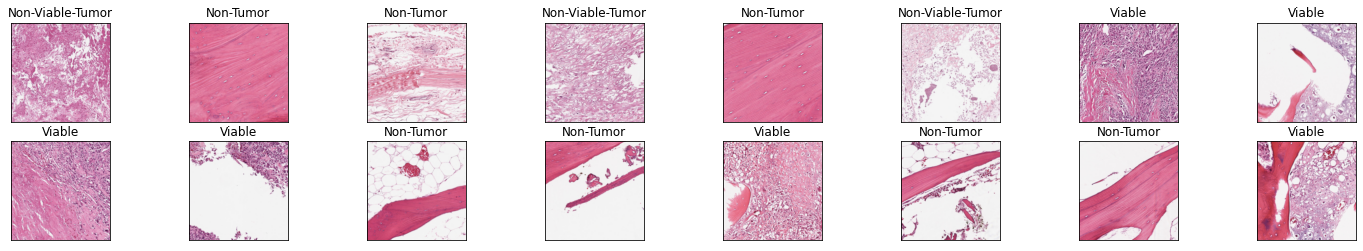

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Converted Image to numpy

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

#### Taking pre-trained model and modifying for feature extraction

In [ ]:
# Taking vgg16 model 
from torchvision import models
vgg19 = models.vgg19(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# change the number of classes  
# We will take 1024 features for every image

vgg19.classifier[2] = nn.Dropout(p= 0.5, inplace= False)
vgg19.classifier[3] = nn.Linear(4096, 1024)
vgg19.classifier[6] = nn.Linear(1024, 1024)
vgg19.classifier[5] = nn.Dropout(p= 0.3, inplace= False)
# freeze convolution weights
for param in vgg19.features.parameters():
    param.requires_grad = False

In [ ]:
# defining modified vgg 19 as our model 
model = vgg19

In [ ]:
from torchvision import models
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Training Model 

In [ ]:
import torch.optim as optim
# optimizer
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9 ) #weight_decay= 5e-4
# optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001, betas= (0.9, 0.999), eps= 1e-8, weight_decay=0)
# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# train for some epochs 
# number of epochs to train the model
n_epochs = 10

# using test set as validation set
valid_loader = test_loader

valid_loss_min = np.Inf # track change in validation loss

valid_list= []  # stores validation losses
train_list= []  # stores train losses

valid_acc = [] # store validation accuracy
train_acc = [] # store train accuracy

for epoch in range(1, n_epochs+1):

    # keep track of training, validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_corrects = 0
    val_corrects = 0

    # trianing the model
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        _,preds = torch.max(output, 1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        train_corrects += torch.sum(preds == target.data)
        
          
    # validate the model 
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        _,preds = torch.max(output, 1)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        val_corrects += torch.sum(preds == target.data) 
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    # calculate accuracy
    t_acc = train_corrects/len(train_loader.sampler)
    v_acc = val_corrects/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTrain Acc: {:4f} \tValidation Acc: {:4f}'.format(
        epoch, train_loss, valid_loss, t_acc, v_acc))
    
    # Using Schedular step
    # scheduler.step()
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'osteosercoma_vgg19.pt')
        valid_loss_min = valid_loss
    
    #storing train and validation looses
    train_list.append(train_loss)
    valid_list.append(valid_loss)
    # storing train and validartion accuracy
    train_acc.append(t_acc)
    valid_acc.append(v_acc)

Epoch: 1 	Training Loss: 2.006499 	Validation Loss: 0.427382 	Train Acc: 0.575328 	Validation Acc: 0.828947
Validation loss decreased (inf --> 0.427382).  Saving model ...
Epoch: 2 	Training Loss: 0.395002 	Validation Loss: 0.360881 	Train Acc: 0.852620 	Validation Acc: 0.868421
Validation loss decreased (0.427382 --> 0.360881).  Saving model ...
Epoch: 3 	Training Loss: 0.268635 	Validation Loss: 0.336809 	Train Acc: 0.906114 	Validation Acc: 0.877193
Validation loss decreased (0.360881 --> 0.336809).  Saving model ...
Epoch: 4 	Training Loss: 0.193818 	Validation Loss: 0.290190 	Train Acc: 0.930131 	Validation Acc: 0.899123
Validation loss decreased (0.336809 --> 0.290190).  Saving model ...
Epoch: 5 	Training Loss: 0.141342 	Validation Loss: 0.279405 	Train Acc: 0.947598 	Validation Acc: 0.890351
Validation loss decreased (0.290190 --> 0.279405).  Saving model ...
Epoch: 6 	Training Loss: 0.107330 	Validation Loss: 0.266906 	Train Acc: 0.972707 	Validation Acc: 0.907895
Validation l

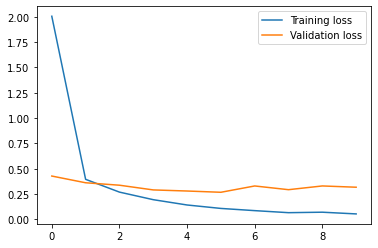

In [ ]:
# plotting the training and validation loss
plt.plot(train_list, label='Training loss')
plt.plot(valid_list, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
train_acc = torch.tensor(train_acc, device= 'cpu')
valid_acc = torch.tensor(valid_acc, device= 'cpu')

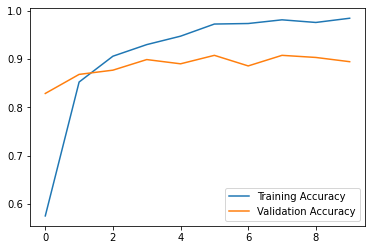

In [ ]:
# plotting the training and validation accuracy
plt.plot(train_acc.cpu(), label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# load best model
model.load_state_dict(torch.load('osteosercoma_vgg19.pt'))

<All keys matched successfully>

In [ ]:
n_corrects= 0
n_samples= 0

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    _, pred = torch.max(output, 1)    
    n_corrects += (pred== target).sum().item()
    n_samples += target.size(0)

print(f'Overall accuracy {(n_corrects / n_samples)*100}%')

Overall accuracy 90.78947368421053%


# Making train and test set for ML Algorithm

getting training feature maps

In [ ]:
# feature extraction for training images

x_train = []
y_train = []
model.eval()
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()      
    output = model(data)
    
    x_train.append(output)
    
    if torch.cuda.is_available():
        target = torch.tensor(target, device= 'cpu')
    target = target.numpy()
    
    target = target.astype(int)
    y_train.append(target)

In [ ]:
len(x_train)

58

getting test feature maps

In [ ]:
# feature extraction for test images

x_test = []
y_test = []
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()      
    output = model(data)
    
    x_test.append(output)
    
    if torch.cuda.is_available():
        target = torch.tensor(target, device= 'cpu')
    target = target.numpy()
    
    target = target.astype(int)
    y_test.append(target)

In [ ]:
x_test[1][1].shape

torch.Size([1024])

In [ ]:
# As we are getting data from dataloader, so data are inserted as batch size (2D List)
# that's why we need to convert this into 1D list 
from itertools import chain
x_train_features = list(chain.from_iterable(x_train))
x_test_features = list(chain.from_iterable(x_test))

print("Total training features: ", len(x_train_features))
print("Total test features: ", len(x_test_features))

Total training features:  916
Total test features:  228


In [ ]:
# converting labels into one dimensional list 
y_train = list(chain.from_iterable(y_train))
y_test = list(chain.from_iterable(y_test))

print("Total training labels: ", len(y_train))
print("Total test labels: ", len(y_test))

Total training labels:  916
Total test labels:  228


converting training feature maps into 2D np array

In [ ]:
# Now we need to convert out features list into 2D array for training 
# And after feature extraction we got features as torch tensors
# We need to convert those tensors into numpy to train in ML algorithm

for i in range(len(x_train_features)):
    # x_train_features[i] = x_train_features[i].numpy()
    if torch.cuda.is_available():
        x_train_features[i] = x_train_features[i].cpu().detach().numpy()   # if use GPU
        
    x_train_features[i] = x_train_features[i].detach().numpy()   # removing gradient 

# converting to numpy 
x_train_features = np.array(x_train_features)
print("Shape of training features: ",x_train_features.shape)

Shape of training features:  (916, 1024)


**converting test features into 2D np array**

In [ ]:
# Now we need to convert out features list into 2D array for training 
# And after feature extraction we got features as torch tensors
# We need to convert those tensors into numpy to train in ML algorithm

for i in range(len(x_test_features)):
    # x_train_features[i] = x_train_features[i].numpy()
    if torch.cuda.is_available():
        x_test_features[i] = x_test_features[i].cpu().detach().numpy()   # if use GPU
        
    x_test_features[i] = x_test_features[i].detach().numpy()   # removing gradient 

# converting to numpy 
x_test_features = np.array(x_test_features)
print("Shape of training features: ",x_test_features.shape)

Shape of training features:  (228, 1024)


converting labels (ground truth) into np array

In [ ]:
#Convert label lists to arrays                
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Shape of training labels: ", y_train.shape)
print("Shape of test labels: ", y_test.shape)

Shape of training labels:  (916,)
Shape of test labels:  (228,)


# ROC-AUC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
train_X = x_train_features
train_Y = y_train
test_X = x_test_features
test_Y = y_test

In [ ]:
# label binarize 
from sklearn.preprocessing import label_binarize
# for train labels 
train_Y = label_binarize(train_Y, classes=[0, 1, 2])
n_classes = train_Y.shape[1]
print(f"Number of class: {n_classes}")

# for test labels 
test_Y = label_binarize(test_Y, classes=[0,1,2])
n_classes = test_Y.shape[1]
print(f"Number of class: {n_classes}")

Number of class: 3
Number of class: 3


In [ ]:
# for Random Forest 
# importing random forest classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Learn to predict each class against the other
rf_classifier = OneVsRestClassifier(
    RandomForestClassifier(n_estimators = 64, criterion = 'gini', ccp_alpha=0.025, random_state = 42)
)
y_score = rf_classifier.fit(train_X, train_Y).predict_proba(test_X)

 # Compute ROC curve and ROC area for each class
rf_fpr = dict()
rf_tpr = dict()
rf_roc_auc = dict()
for i in range(n_classes):
    rf_fpr[i], rf_tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
    rf_roc_auc[i] = auc(rf_fpr[i], rf_tpr[i])

# Compute micro-average ROC curve and ROC area
rf_fpr["micro"], rf_tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
rf_roc_auc["micro"] = auc(rf_fpr["micro"], rf_tpr["micro"])

# getting micro average 
print(f"Micro average: {rf_roc_auc['micro']}")

# macro average 
# First aggregate all false positive rates
rf_all_fpr = np.unique(np.concatenate([rf_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
rf_mean_tpr = np.zeros_like(rf_all_fpr)
for i in range(n_classes):
    rf_mean_tpr += np.interp(rf_all_fpr, rf_fpr[i], rf_tpr[i])

# Finally average it and compute AUC
rf_mean_tpr /= n_classes

rf_fpr["macro"] = rf_all_fpr
rf_tpr["macro"] = rf_mean_tpr
rf_roc_auc["macro"] = auc(rf_fpr["macro"], rf_tpr["macro"])

print(f"Macro average ROC: {rf_roc_auc['macro']}")

Micro average: 0.9128962757771621
Macro average ROC: 0.9493001189605627


In [ ]:
# XGBoost
import xgboost as xgb

# Learn to predict each class against the other
xg_classifier = OneVsRestClassifier(
    xgb.XGBClassifier(learning_rate= 0.006)
)
y_score = xg_classifier.fit(train_X, train_Y).predict_proba(test_X)

 # Compute ROC curve and ROC area for each class
xg_fpr = dict()
xg_tpr = dict()
xg_roc_auc = dict()
for i in range(n_classes):
    xg_fpr[i], xg_tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
    xg_roc_auc[i] = auc(xg_fpr[i], xg_tpr[i])

# Compute micro-average ROC curve and ROC area
xg_fpr["micro"], xg_tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
xg_roc_auc["micro"] = auc(xg_fpr["micro"], xg_tpr["micro"])

# getting micro average 
print(f"Micro average: {xg_roc_auc['micro']}")

# macro average 
# First aggregate all false positive rates
xg_all_fpr = np.unique(np.concatenate([xg_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
xg_mean_tpr = np.zeros_like(xg_all_fpr)
for i in range(n_classes):
    xg_mean_tpr += np.interp(xg_all_fpr, xg_fpr[i], xg_tpr[i])

# Finally average it and compute AUC
xg_mean_tpr /= n_classes

xg_fpr["macro"] = xg_all_fpr
xg_tpr["macro"] = xg_mean_tpr
xg_roc_auc["macro"] = auc(xg_fpr["macro"], xg_tpr["macro"])

print(f"Macro average ROC: {xg_roc_auc['macro']}")

Micro average: 0.930040974145891
Macro average ROC: 0.9293104572484027


In [ ]:
# For LGBM 
from lightgbm import LGBMClassifier

# Learn to predict each class against the other
lgbm_classifier = OneVsRestClassifier(
    LGBMClassifier(learning_rate= 0.006)
)
y_score = lgbm_classifier.fit(train_X, train_Y).predict_proba(test_X)

 # Compute ROC curve and ROC area for each class
lgbm_fpr = dict()
lgbm_tpr = dict()
lgbm_roc_auc = dict()
for i in range(n_classes):
    lgbm_fpr[i], lgbm_tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
    lgbm_roc_auc[i] = auc(lgbm_fpr[i], lgbm_tpr[i])

# Compute micro-average ROC curve and ROC area
lgbm_fpr["micro"], lgbm_tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
lgbm_roc_auc["micro"] = auc(lgbm_fpr["micro"], lgbm_tpr["micro"])

# getting micro average 
print(f"Micro average: {lgbm_roc_auc['micro']}")

# macro average 
# First aggregate all false positive rates
lgbm_all_fpr = np.unique(np.concatenate([lgbm_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
lgbm_mean_tpr = np.zeros_like(lgbm_all_fpr)
for i in range(n_classes):
    lgbm_mean_tpr += np.interp(lgbm_all_fpr, lgbm_fpr[i], lgbm_tpr[i])

# Finally average it and compute AUC
lgbm_mean_tpr /= n_classes

lgbm_fpr["macro"] = lgbm_all_fpr
lgbm_tpr["macro"] = lgbm_mean_tpr
lgbm_roc_auc["macro"] = auc(lgbm_fpr["macro"], lgbm_tpr["macro"])

print(f"Macro average ROC: {lgbm_roc_auc['macro']}")

Micro average: 0.9131271160357033
Macro average ROC: 0.9416804472317034


In [ ]:
# For Decision tree
from sklearn.tree import DecisionTreeClassifier

# Learn to predict each class against the other
dt_classifier = OneVsRestClassifier(
    DecisionTreeClassifier(max_depth =7, ccp_alpha=0.025, random_state = 42)
)
y_score = dt_classifier.fit(train_X, train_Y).predict_proba(test_X)

 # Compute ROC curve and ROC area for each class
dt_fpr = dict()
dt_tpr = dict()
dt_roc_auc = dict()
for i in range(n_classes):
    dt_fpr[i], dt_tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
    dt_roc_auc[i] = auc(dt_fpr[i], dt_tpr[i])

# Compute micro-average ROC curve and ROC area
dt_fpr["micro"], dt_tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
dt_roc_auc["micro"] = auc(dt_fpr["micro"], dt_tpr["micro"])

# getting micro average 
print(f"Micro average: {dt_roc_auc['micro']}")

# macro average 
# First aggregate all false positive rates
dt_all_fpr = np.unique(np.concatenate([dt_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
dt_mean_tpr = np.zeros_like(dt_all_fpr)
for i in range(n_classes):
    dt_mean_tpr += np.interp(dt_all_fpr, dt_fpr[i], dt_tpr[i])

# Finally average it and compute AUC
dt_mean_tpr /= n_classes

dt_fpr["macro"] = dt_all_fpr
dt_tpr["macro"] = dt_mean_tpr
dt_roc_auc["macro"] = auc(dt_fpr["macro"], dt_tpr["macro"])

print(f"Macro average ROC: {dt_roc_auc['macro']}")

Micro average: 0.8142553477993228
Macro average ROC: 0.7732294954083992


In [ ]:
from sklearn.neural_network import MLPClassifier
# Learn to predict each class against the other
mlp_classifier = OneVsRestClassifier(
    MLPClassifier(random_state=1, max_iter=200)
)
y_score = mlp_classifier.fit(train_X, train_Y).predict_proba(test_X)

# Compute ROC curve and ROC area for each class
mlp_fpr = dict()
mlp_tpr = dict()
mlp_roc_auc = dict()
for i in range(n_classes):
    mlp_fpr[i], mlp_tpr[i], _ = roc_curve(test_Y[:, i], y_score[:, i])
    mlp_roc_auc[i] = auc(mlp_fpr[i], mlp_tpr[i])

# Compute micro-average ROC curve and ROC area
mlp_fpr["micro"], mlp_tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
mlp_roc_auc["micro"] = auc(mlp_fpr["micro"], mlp_tpr["micro"])

print(f"Micro average: {mlp_roc_auc['micro']}")

# First aggregate all false positive rates
mlp_all_fpr = np.unique(np.concatenate([mlp_fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mlp_mean_tpr = np.zeros_like(mlp_all_fpr)
for i in range(n_classes):
    mlp_mean_tpr += np.interp(mlp_all_fpr, mlp_fpr[i], mlp_tpr[i])

# Finally average it and compute AUC
mlp_mean_tpr /= n_classes

mlp_fpr["macro"] = mlp_all_fpr
mlp_tpr["macro"] = mlp_mean_tpr
mlp_roc_auc["macro"] = auc(mlp_fpr["macro"], mlp_tpr["macro"])

print(f"ROC Macro: {mlp_roc_auc['macro']}")
print(f"Micro average: {mlp_roc_auc['micro']}")

Micro average: 0.9751461988304094
ROC Macro: 0.9759395551307565
Micro average: 0.9751461988304094


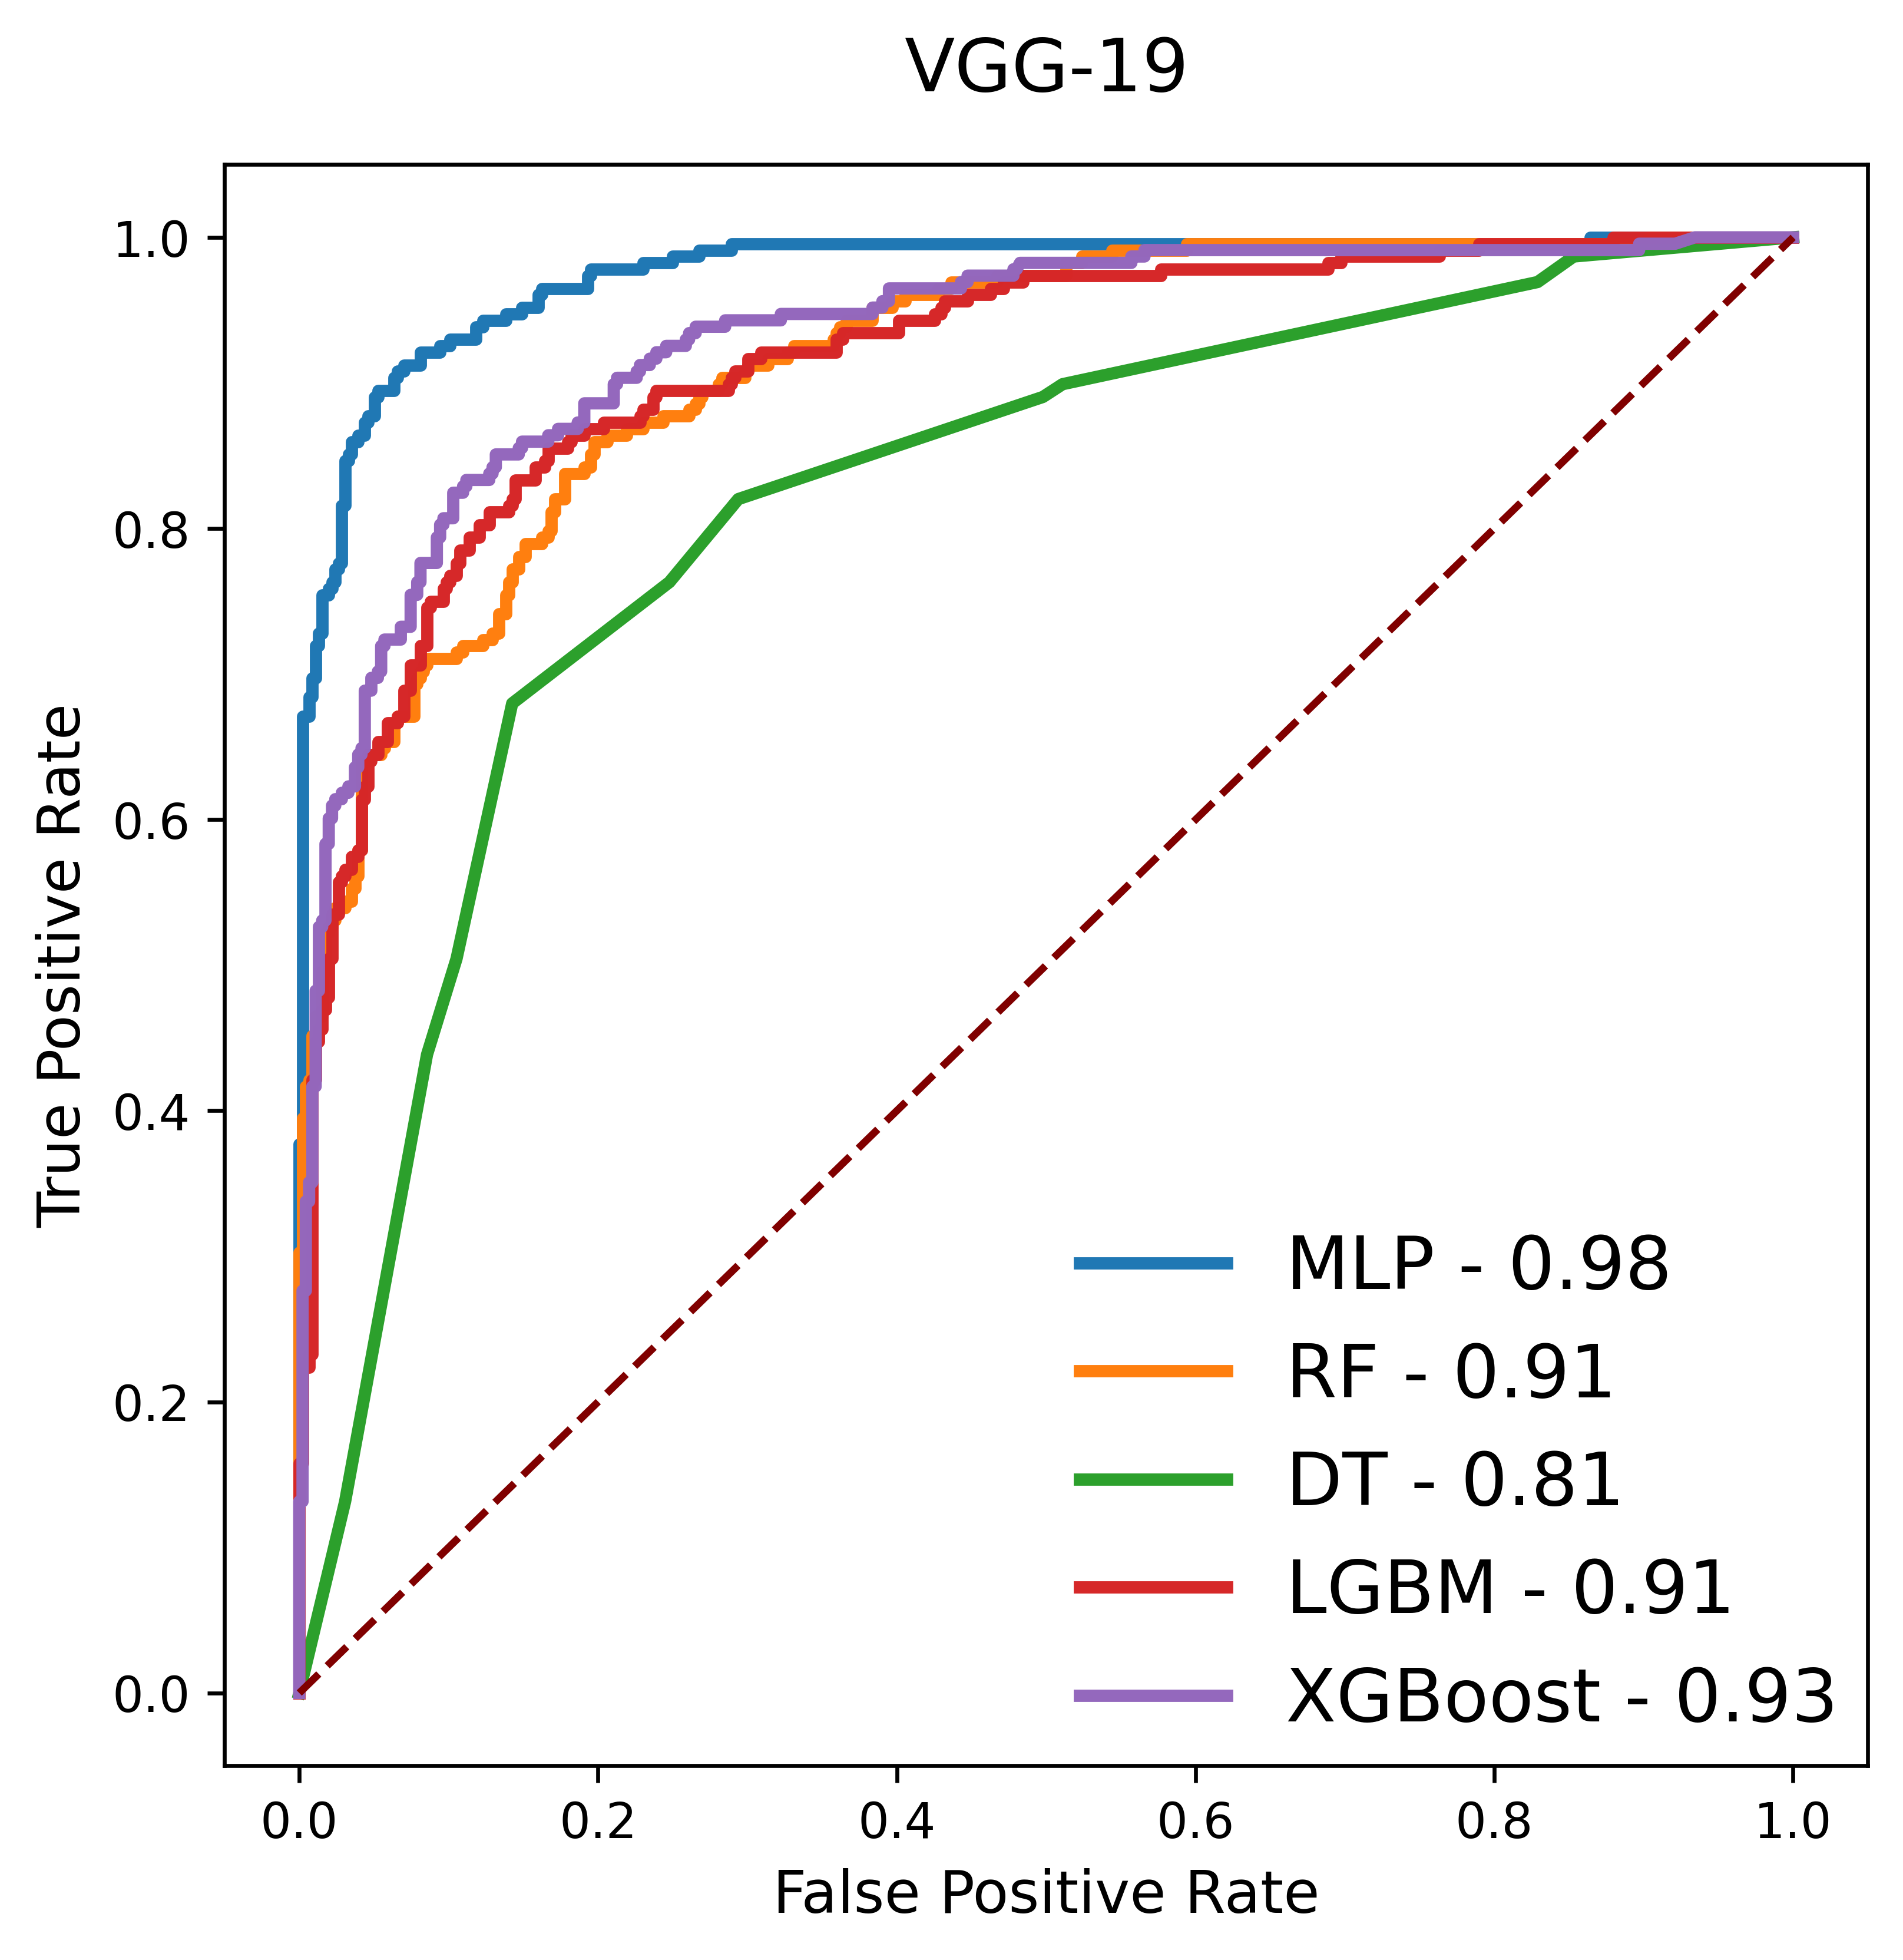

In [ ]:
# Plot all ROC curves
plt_1 = plt.figure(figsize=(6,6))
plt.plot(
    mlp_fpr["micro"],
    mlp_tpr["micro"],
    label="MLP - {0:0.2f}".format(mlp_roc_auc["micro"]),
    
    alpha = 2,
    linewidth=2.5,
)

plt.plot(
    rf_fpr["micro"],
    rf_tpr["micro"],
    label="RF - {0:0.2f}".format(rf_roc_auc["micro"]),
    
    alpha = 2,
    linewidth=2.5,
)

plt.plot(
    dt_fpr["micro"],
    dt_tpr["micro"],
    label="DT - {0:0.2f}".format(dt_roc_auc["micro"]),
    
    alpha = 1,
    linewidth=2.5,
)

plt.plot(
    lgbm_fpr["micro"],
    lgbm_tpr["micro"],
    label="LGBM - {0:0.2f}".format(lgbm_roc_auc["micro"]),
    
    alpha = 2,
    linewidth=2.5,
)
plt.plot(
    xg_fpr['micro'],
    xg_tpr['micro'],
    
    alpha = 2, 
    linewidth=2.5,
    label="XGBoost - %0.2f" % xg_roc_auc['micro'],
)

# change resolution
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

plt.plot([0, 1], [0, 1], "k--", lw=1.5, color='maroon')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.title("VGG-19", pad= 15, fontsize= 15)
plt.legend(loc="lower right", frameon=False, fontsize=15,borderaxespad=0.)
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/vgg-19.png")
plt.show()

# Applying ML Algorithm

### XGBOOST

In [ ]:
#XGBOOST
import xgboost as xgb

# taking XGBClassifier as our model
model = xgb.XGBClassifier(learning_rate= 0.006)

# fit our training data into model
model.fit(x_train_features, y_train) #For sklearn no one hot encoding

XGBClassifier(learning_rate=0.006, objective='multi:softprob')

In [ ]:
#Now predict using the trained RF model. 
prediction = model.predict(x_test_features)

In [ ]:
prediction

array([1, 1, 0, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2,
       0, 2, 0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2,
       2, 0, 0, 1, 0, 1, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2,
       1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 1, 2, 1, 0, 0, 0,
       2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 2, 2,
       1, 2, 2, 0, 1, 2, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 0,
       2, 0, 0, 1, 2, 0, 0, 2])

**Accuracy**

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, prediction)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.838


**Matthews Correlation Coefficient (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, prediction)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.747


**ROC-AUC**

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

clf = xgb.XGBClassifier(learning_rate= 0.006).fit(x_train_features, y_train)
roc_auc = roc_auc_score(y_test, clf.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.941


Confusion Matrix

In [ ]:
# Function to plot confusion matrix

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize= False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
        title = "Normalized Confusion Matrix"
    else:
        # print('Confusion matrix, without normalization')
        title = "Confusion Matrix"

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

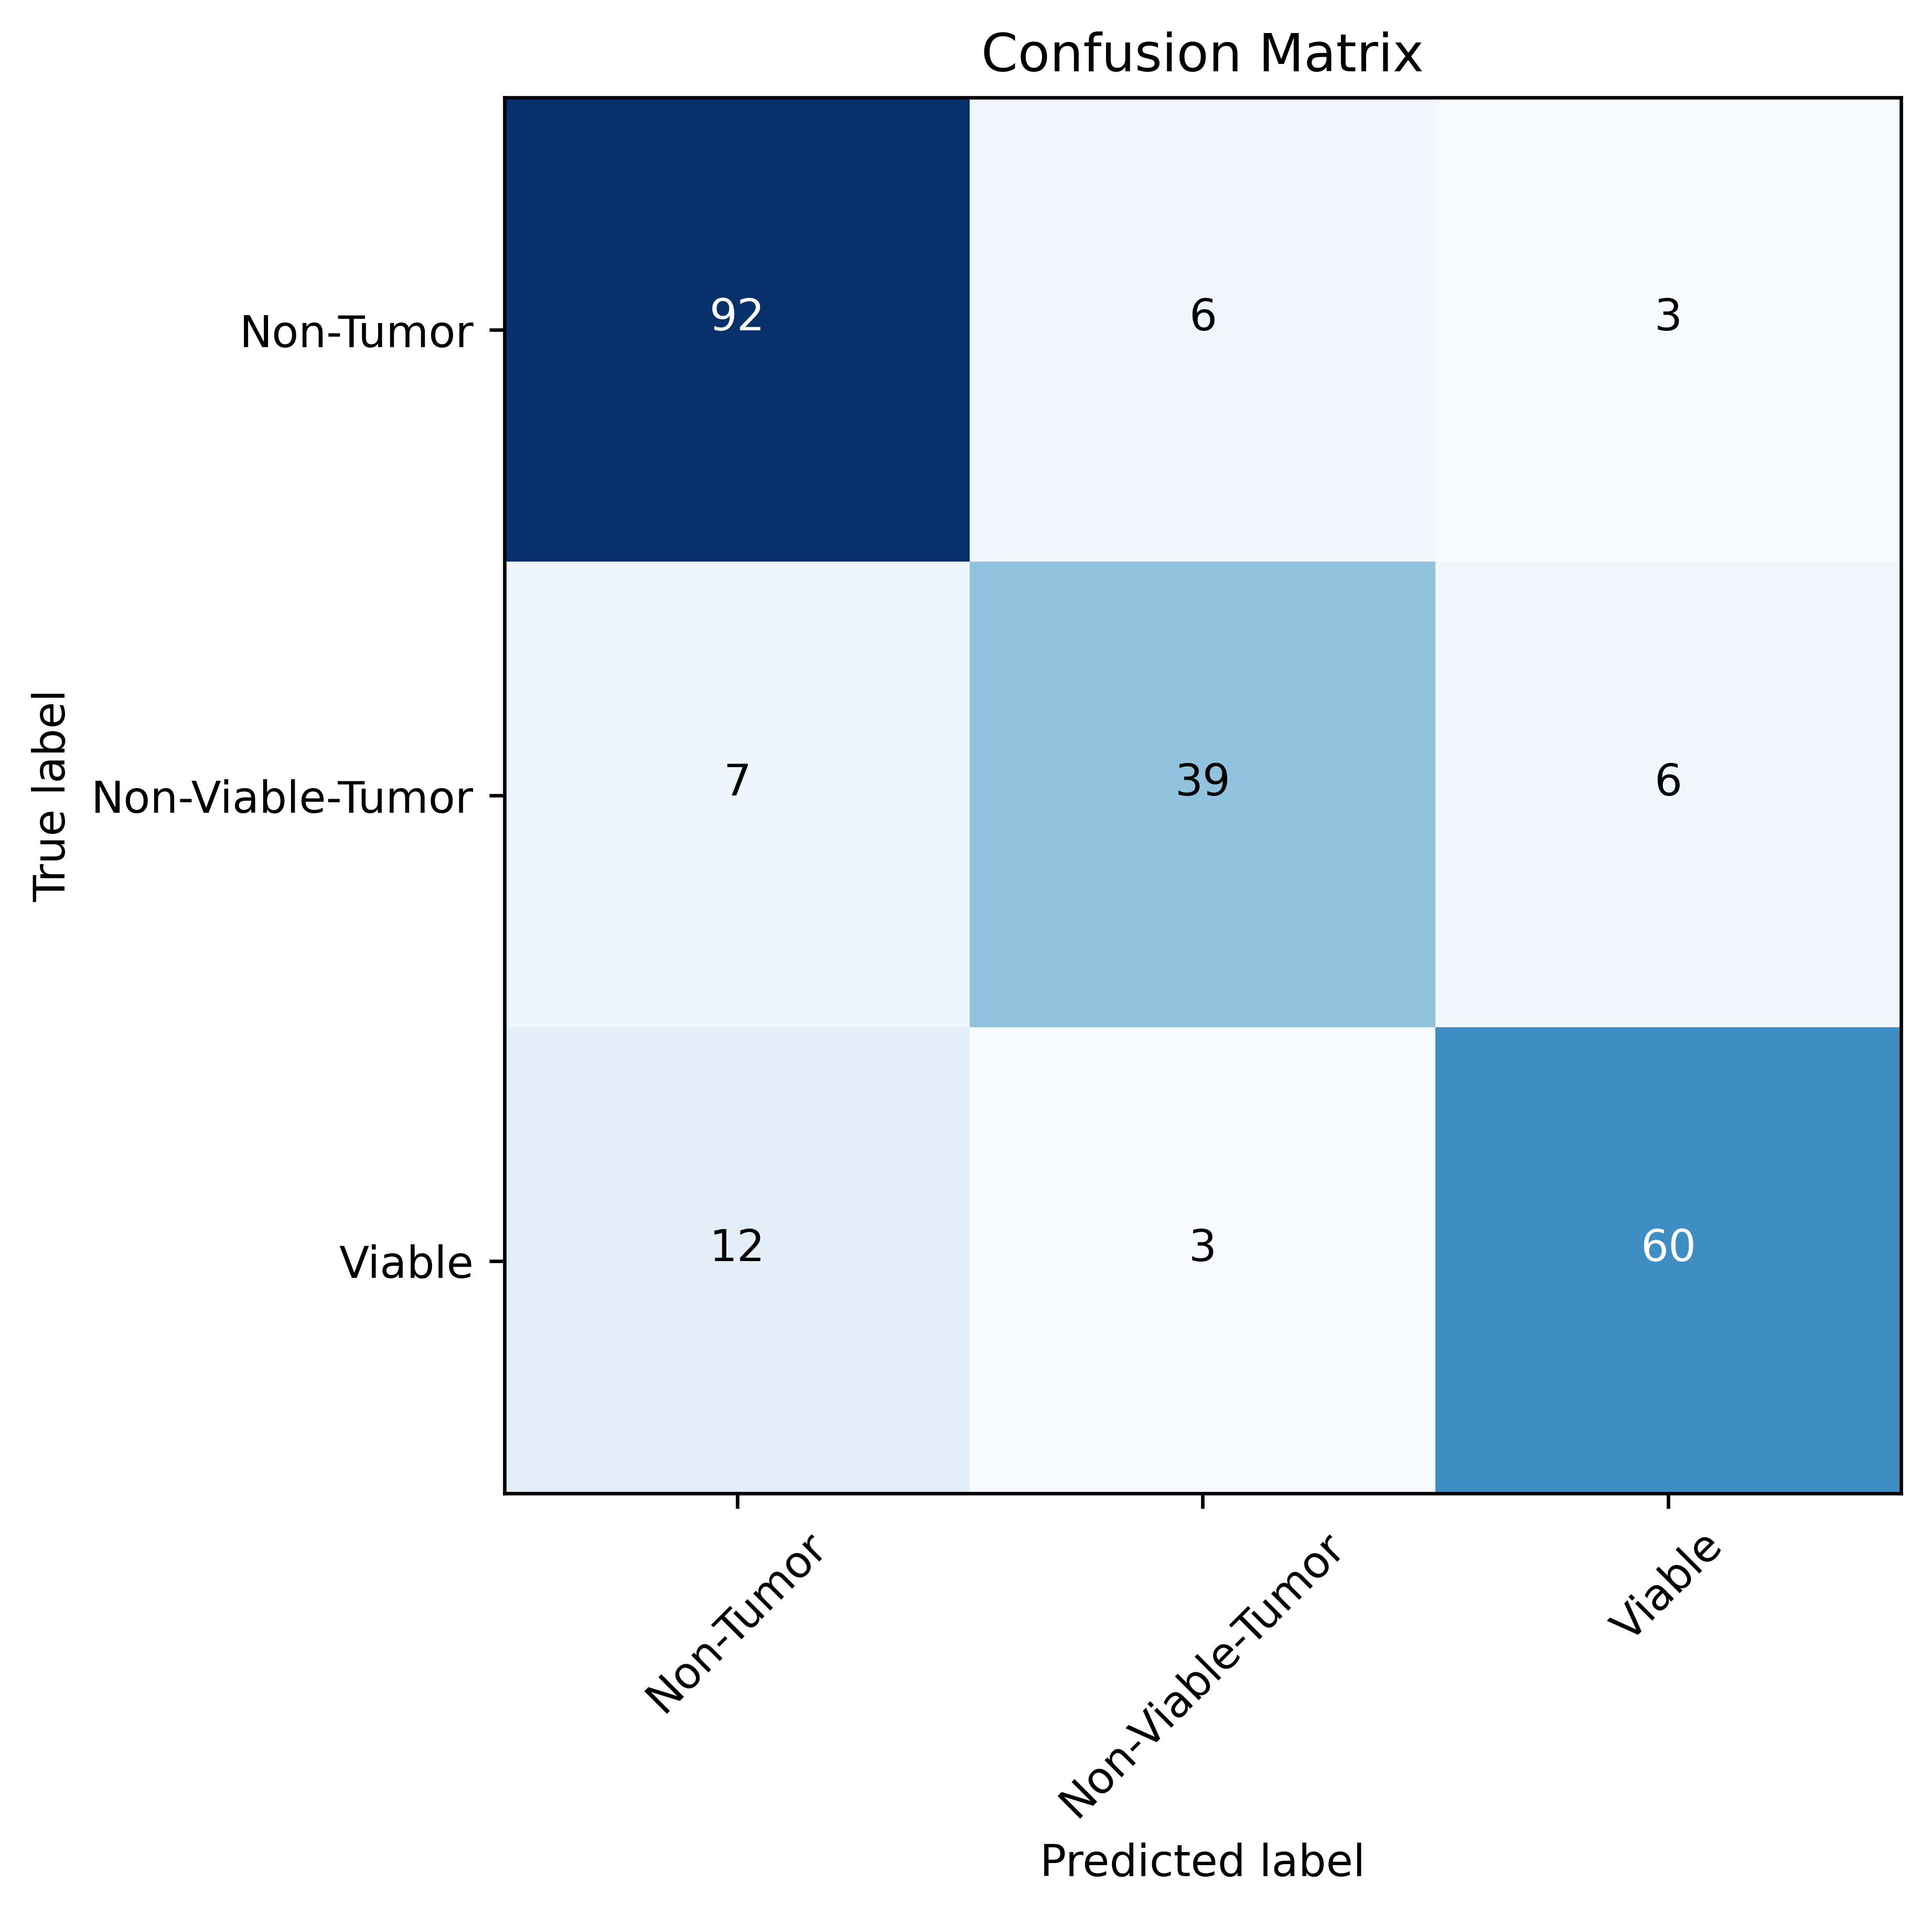

In [ ]:
# getting confusion matrix 
conf_matrix = confusion_matrix(y_test, prediction)

# plotting confusion matrix without normalization
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

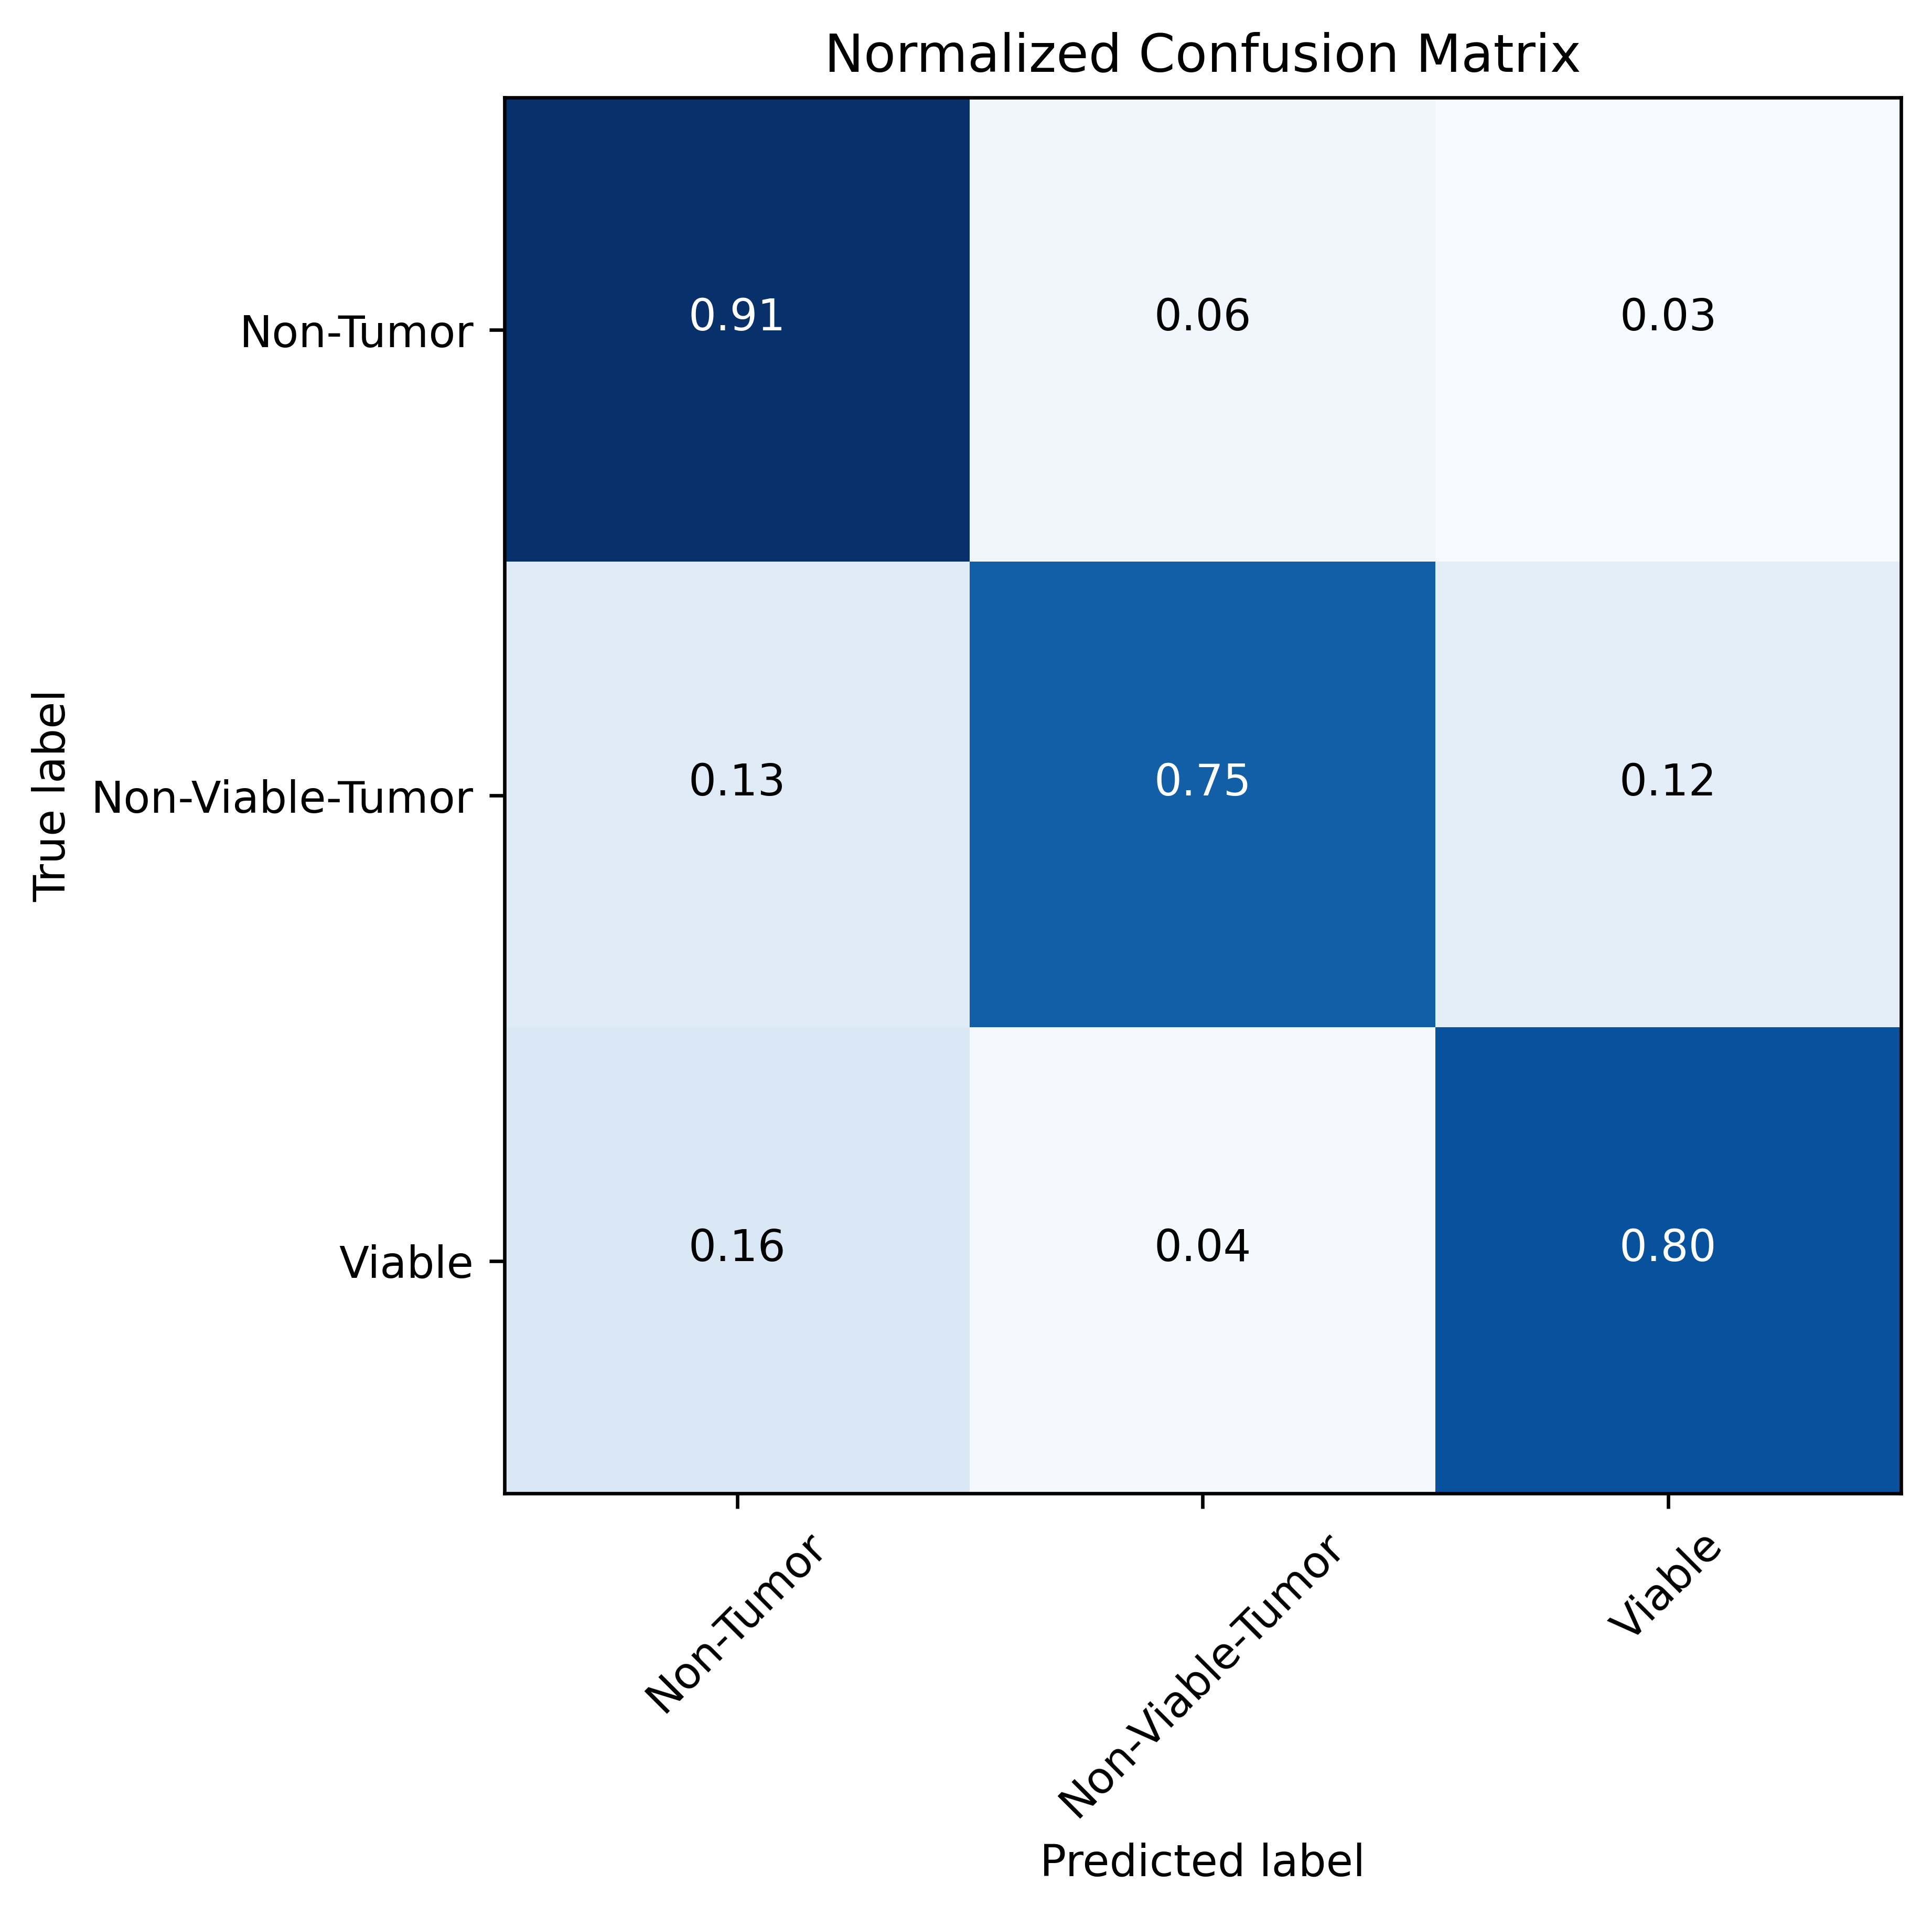

In [ ]:
# plotting confusion matrix with normalization
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       101
           1       0.81      0.75      0.78        52
           2       0.87      0.80      0.83        75

    accuracy                           0.84       228
   macro avg       0.84      0.82      0.83       228
weighted avg       0.84      0.84      0.84       228



classification report by formula

In [ ]:
# function to measure TP, FP, TN, FN

def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, prediction)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.829     	      0.836      	   0.839   
  1   Non-Viable-Tumor     0.812     	      0.582      	   0.944   
  2        Viable           0.87      	      0.682      	   0.936   


#### specificity and sensitivity

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in [0,1,2]:
     prec,recall,_,_ = precision_recall_fscore_support(y_test==l,
                                                  prediction==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

data = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
# data['class_name'] = classes
df2 = data.assign(class_name=['Non-Tumor', 'Non-Viable-Tumor', 'Viable'])
df2

,class,sensitivity,specificity,class_name
0,0,0.923077,0.936937,Non-Tumor
1,1,0.973118,0.857143,Non-Viable-Tumor
2,2,0.960784,0.906667,Viable


## Random Forest

In [ ]:
# importing random forest classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 64, criterion = 'gini', ccp_alpha=0.025, random_state = 42)
classifier.fit(x_train_features, y_train)

RandomForestClassifier(ccp_alpha=0.025, n_estimators=64, random_state=42)

In [ ]:
# prediciting on test data
y_pred = classifier.predict(x_test_features)

In [ ]:
y_pred

array([1, 1, 0, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2,
       0, 2, 0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2,
       2, 0, 0, 1, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2,
       1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 1, 2, 1, 0, 0, 0,
       2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 0, 2, 0, 1, 0, 0, 2, 0, 1, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 2,
       1, 2, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 0,
       2, 0, 0, 1, 0, 1, 0, 2])

**Accuracy**

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, y_pred)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.737


**Matthews Correlation Coefficient (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, y_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.602


**ROC-AUC**

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, classifier.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.947


**confusion matrix**

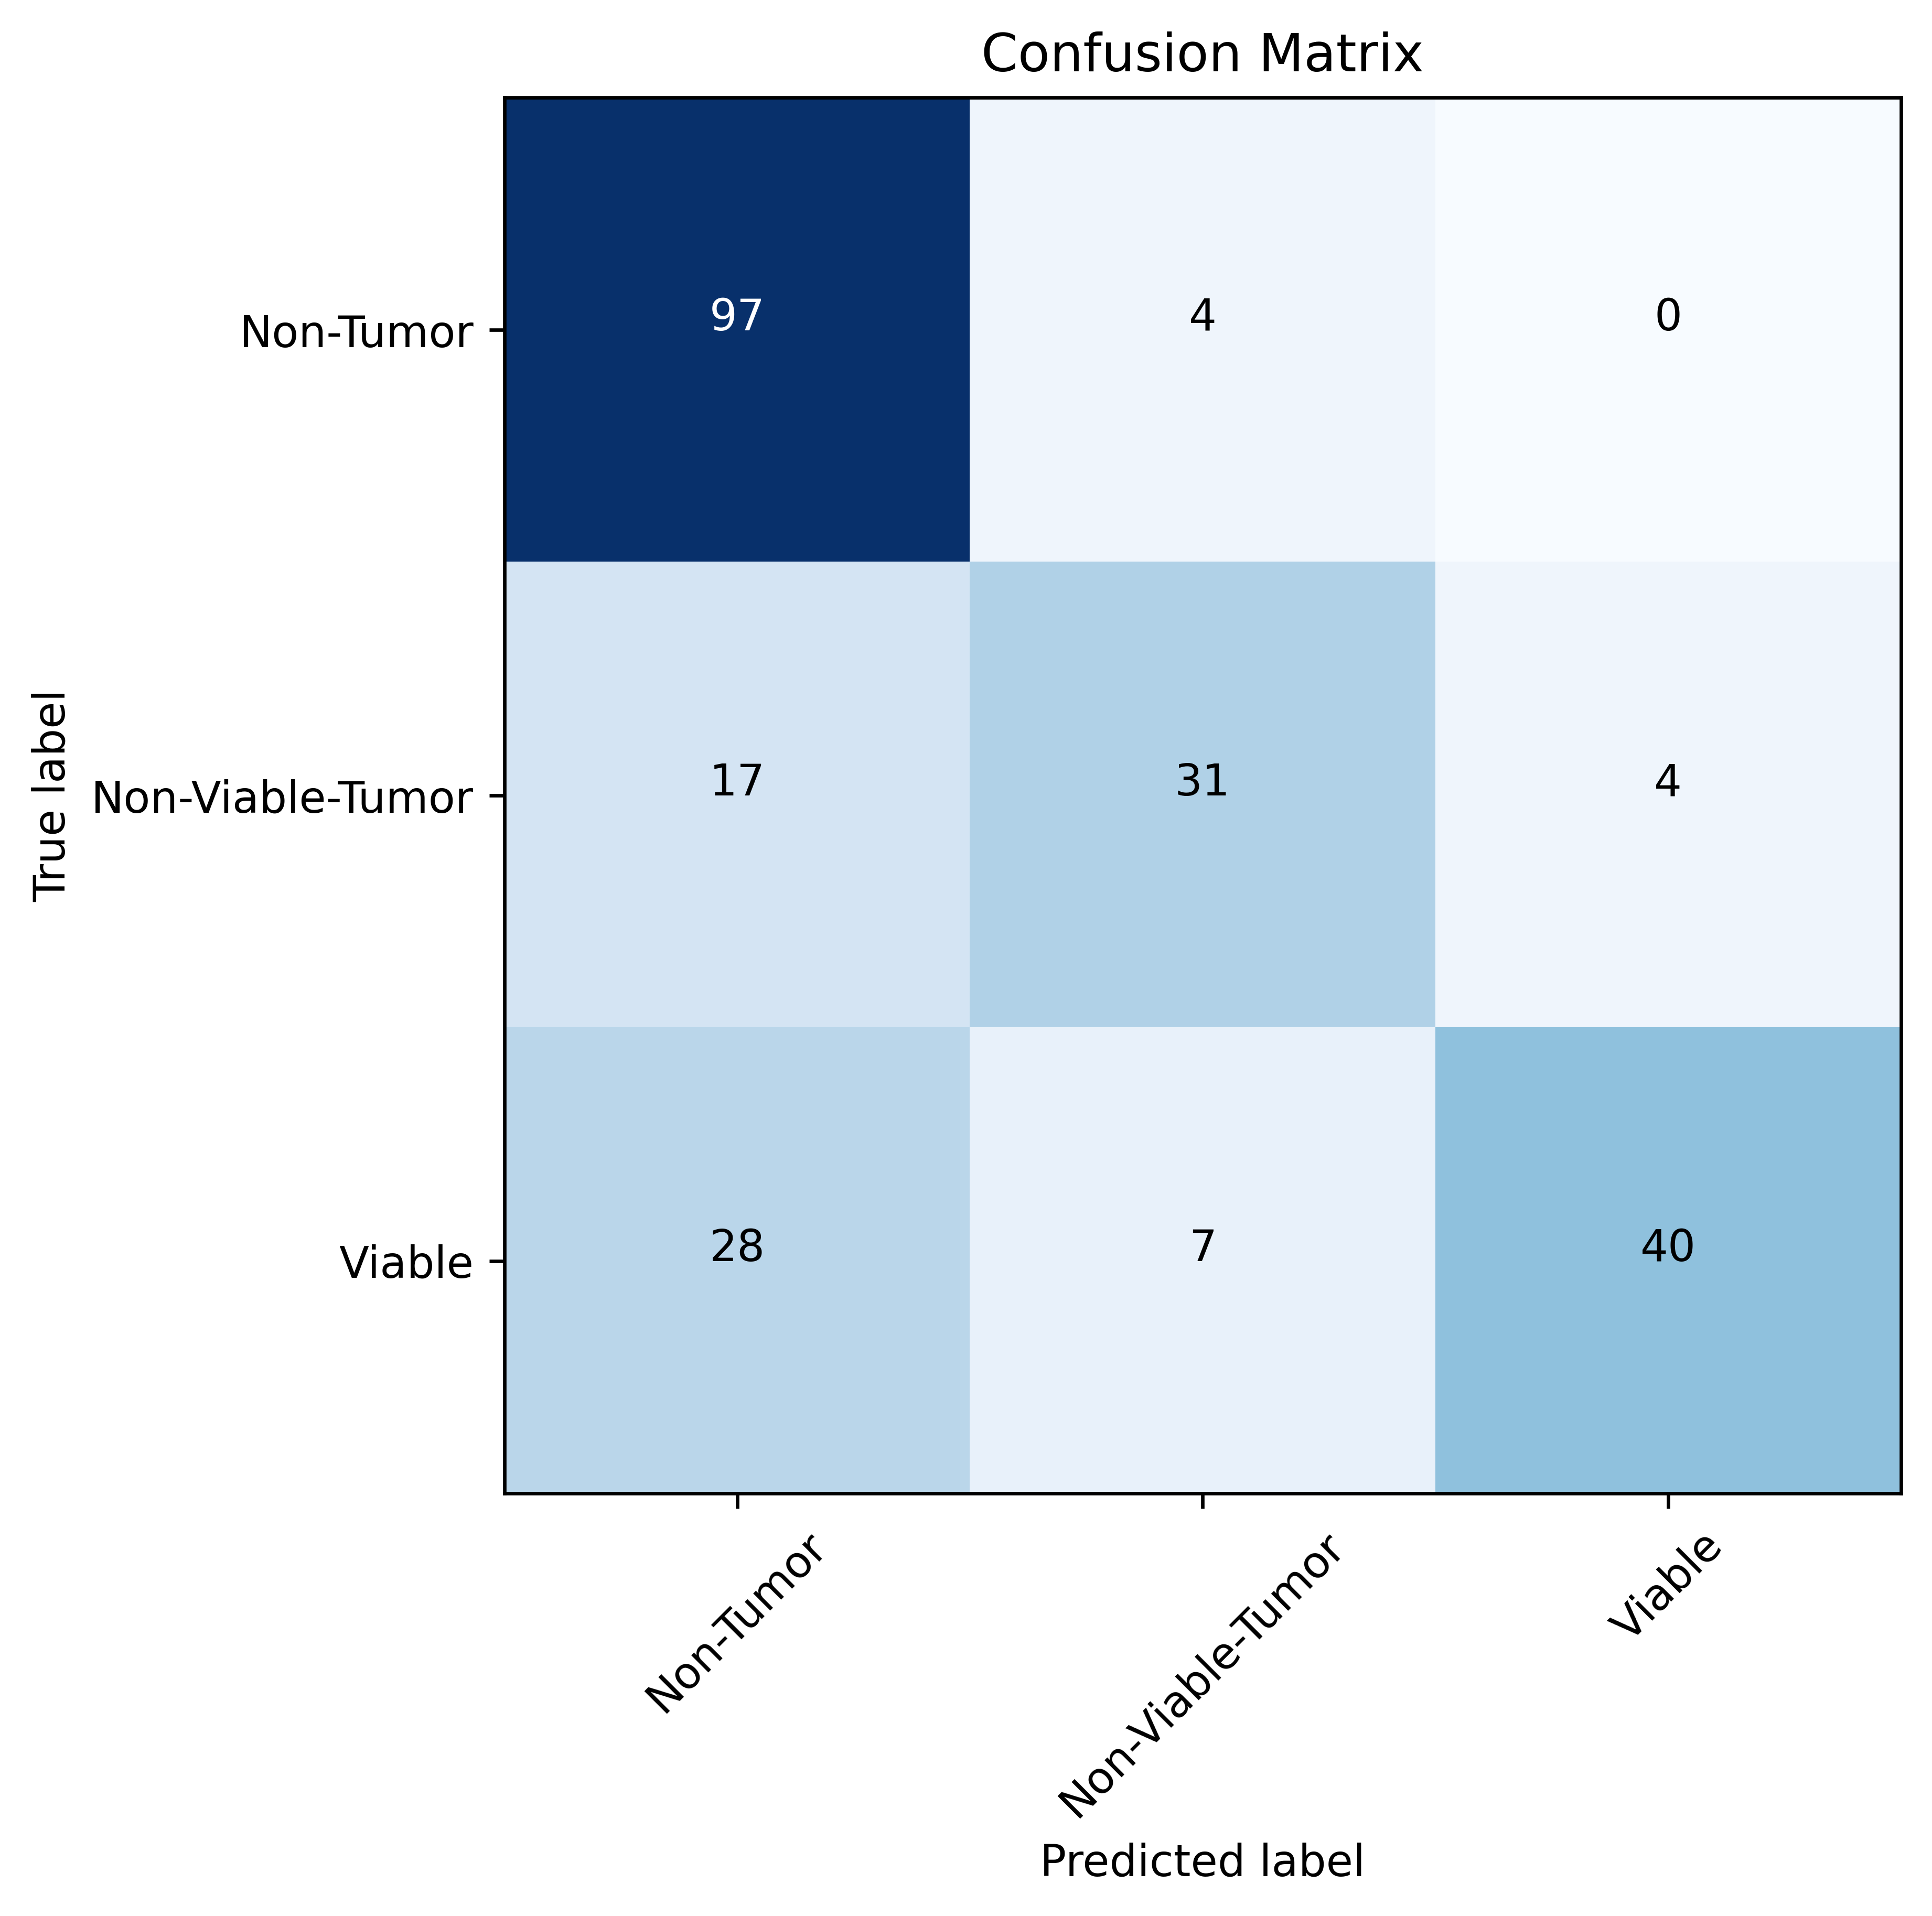

In [ ]:
# getting confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred)

# plotting confusion matrix without normalization
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

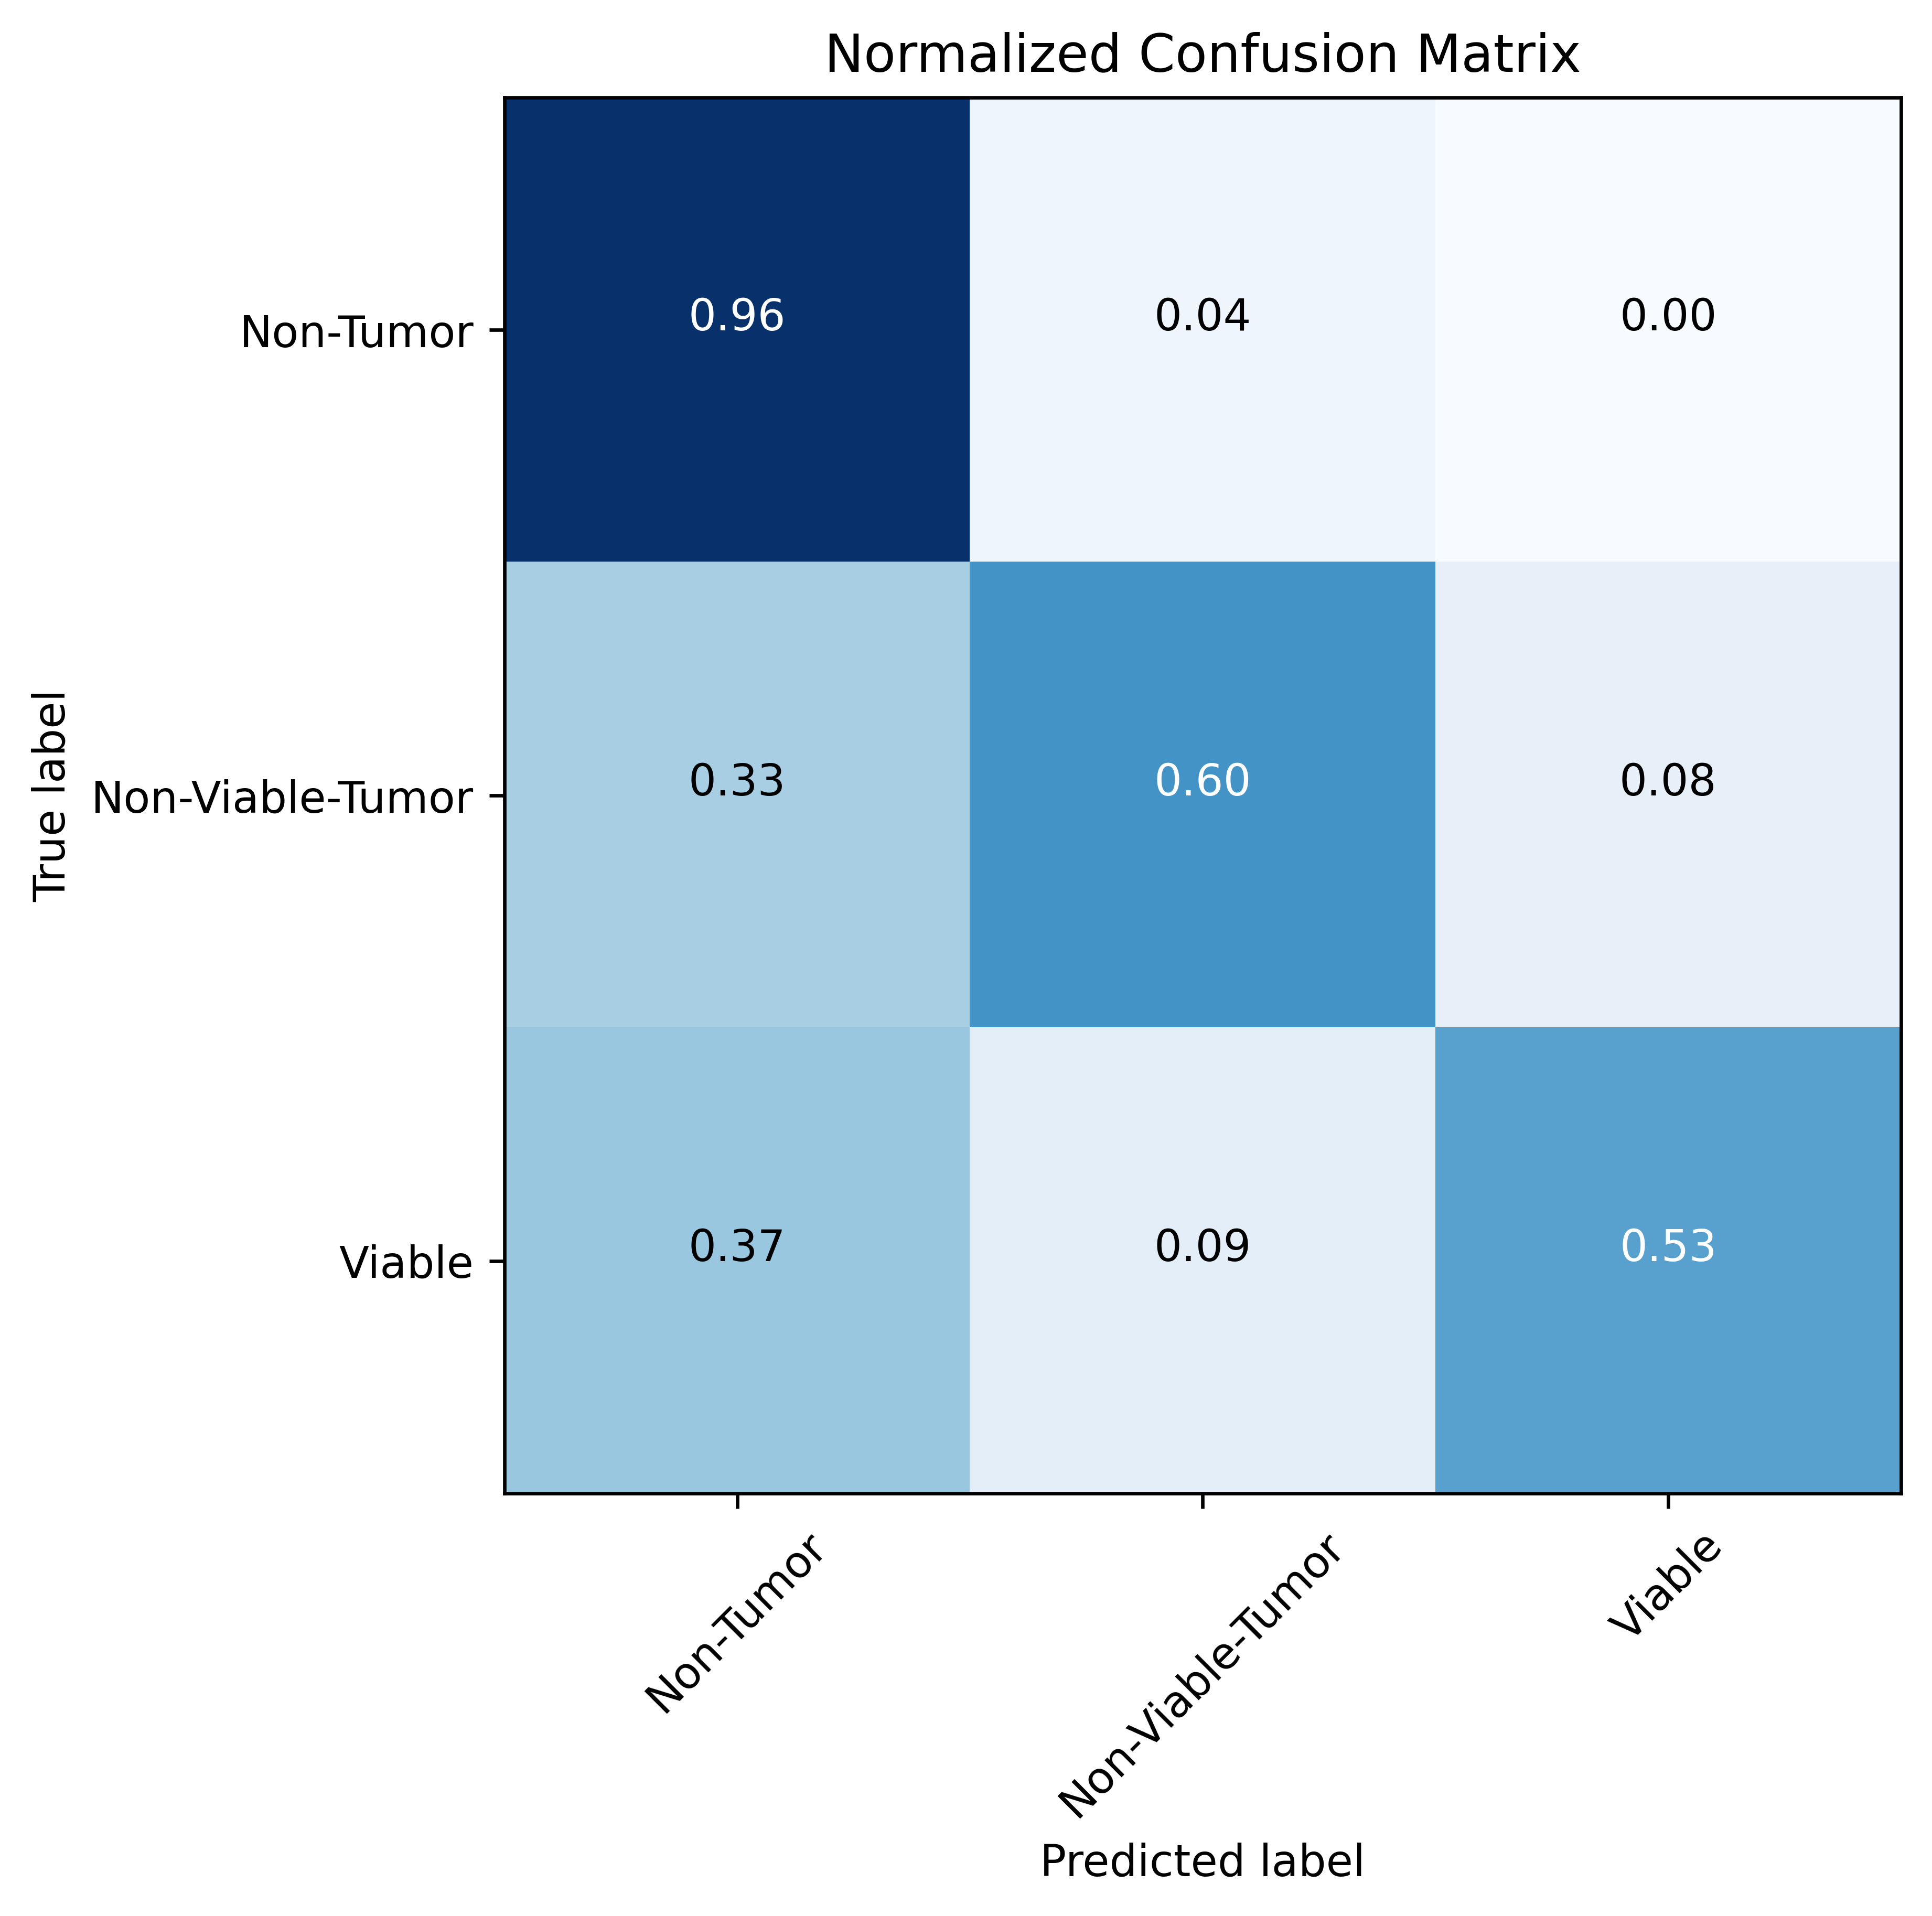

In [ ]:
# plotting confusion matrix with normalization
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

**classification report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.96      0.80       101
           1       0.74      0.60      0.66        52
           2       0.91      0.53      0.67        75

    accuracy                           0.74       228
   macro avg       0.78      0.70      0.71       228
weighted avg       0.77      0.74      0.73       228



**specificity and sensitivity**

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, y_pred)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.683     	      0.866      	   0.612   
  1   Non-Viable-Tumor     0.738     	      0.388      	   0.926   
  2        Viable          0.909      	      0.417      	    0.97   


## Light Gradient Boosting (LGBM)

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
# fit the model on the whole dataset
lgbm_model = LGBMClassifier(learning_rate= 0.006)

# fit our training data into lgbm classifier
lgbm_model.fit(x_train_features, y_train)

LGBMClassifier(learning_rate=0.006)

In [ ]:
# predicting test features using LGBM classifier
lgbm_pred = lgbm_model.predict(x_test_features)

In [ ]:
lgbm_pred

array([1, 1, 0, 0, 2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2,
       0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2,
       0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2,
       1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 1, 2, 1, 0, 0, 0,
       2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 2, 2,
       1, 2, 2, 0, 1, 2, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 0,
       2, 0, 0, 1, 2, 0, 0, 2])

**Accuracy**

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, lgbm_pred)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.768


**Matthews Correlation Coefficient (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, lgbm_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.649


**ROC AUC**

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, lgbm_model.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.946


**confusion matrix**

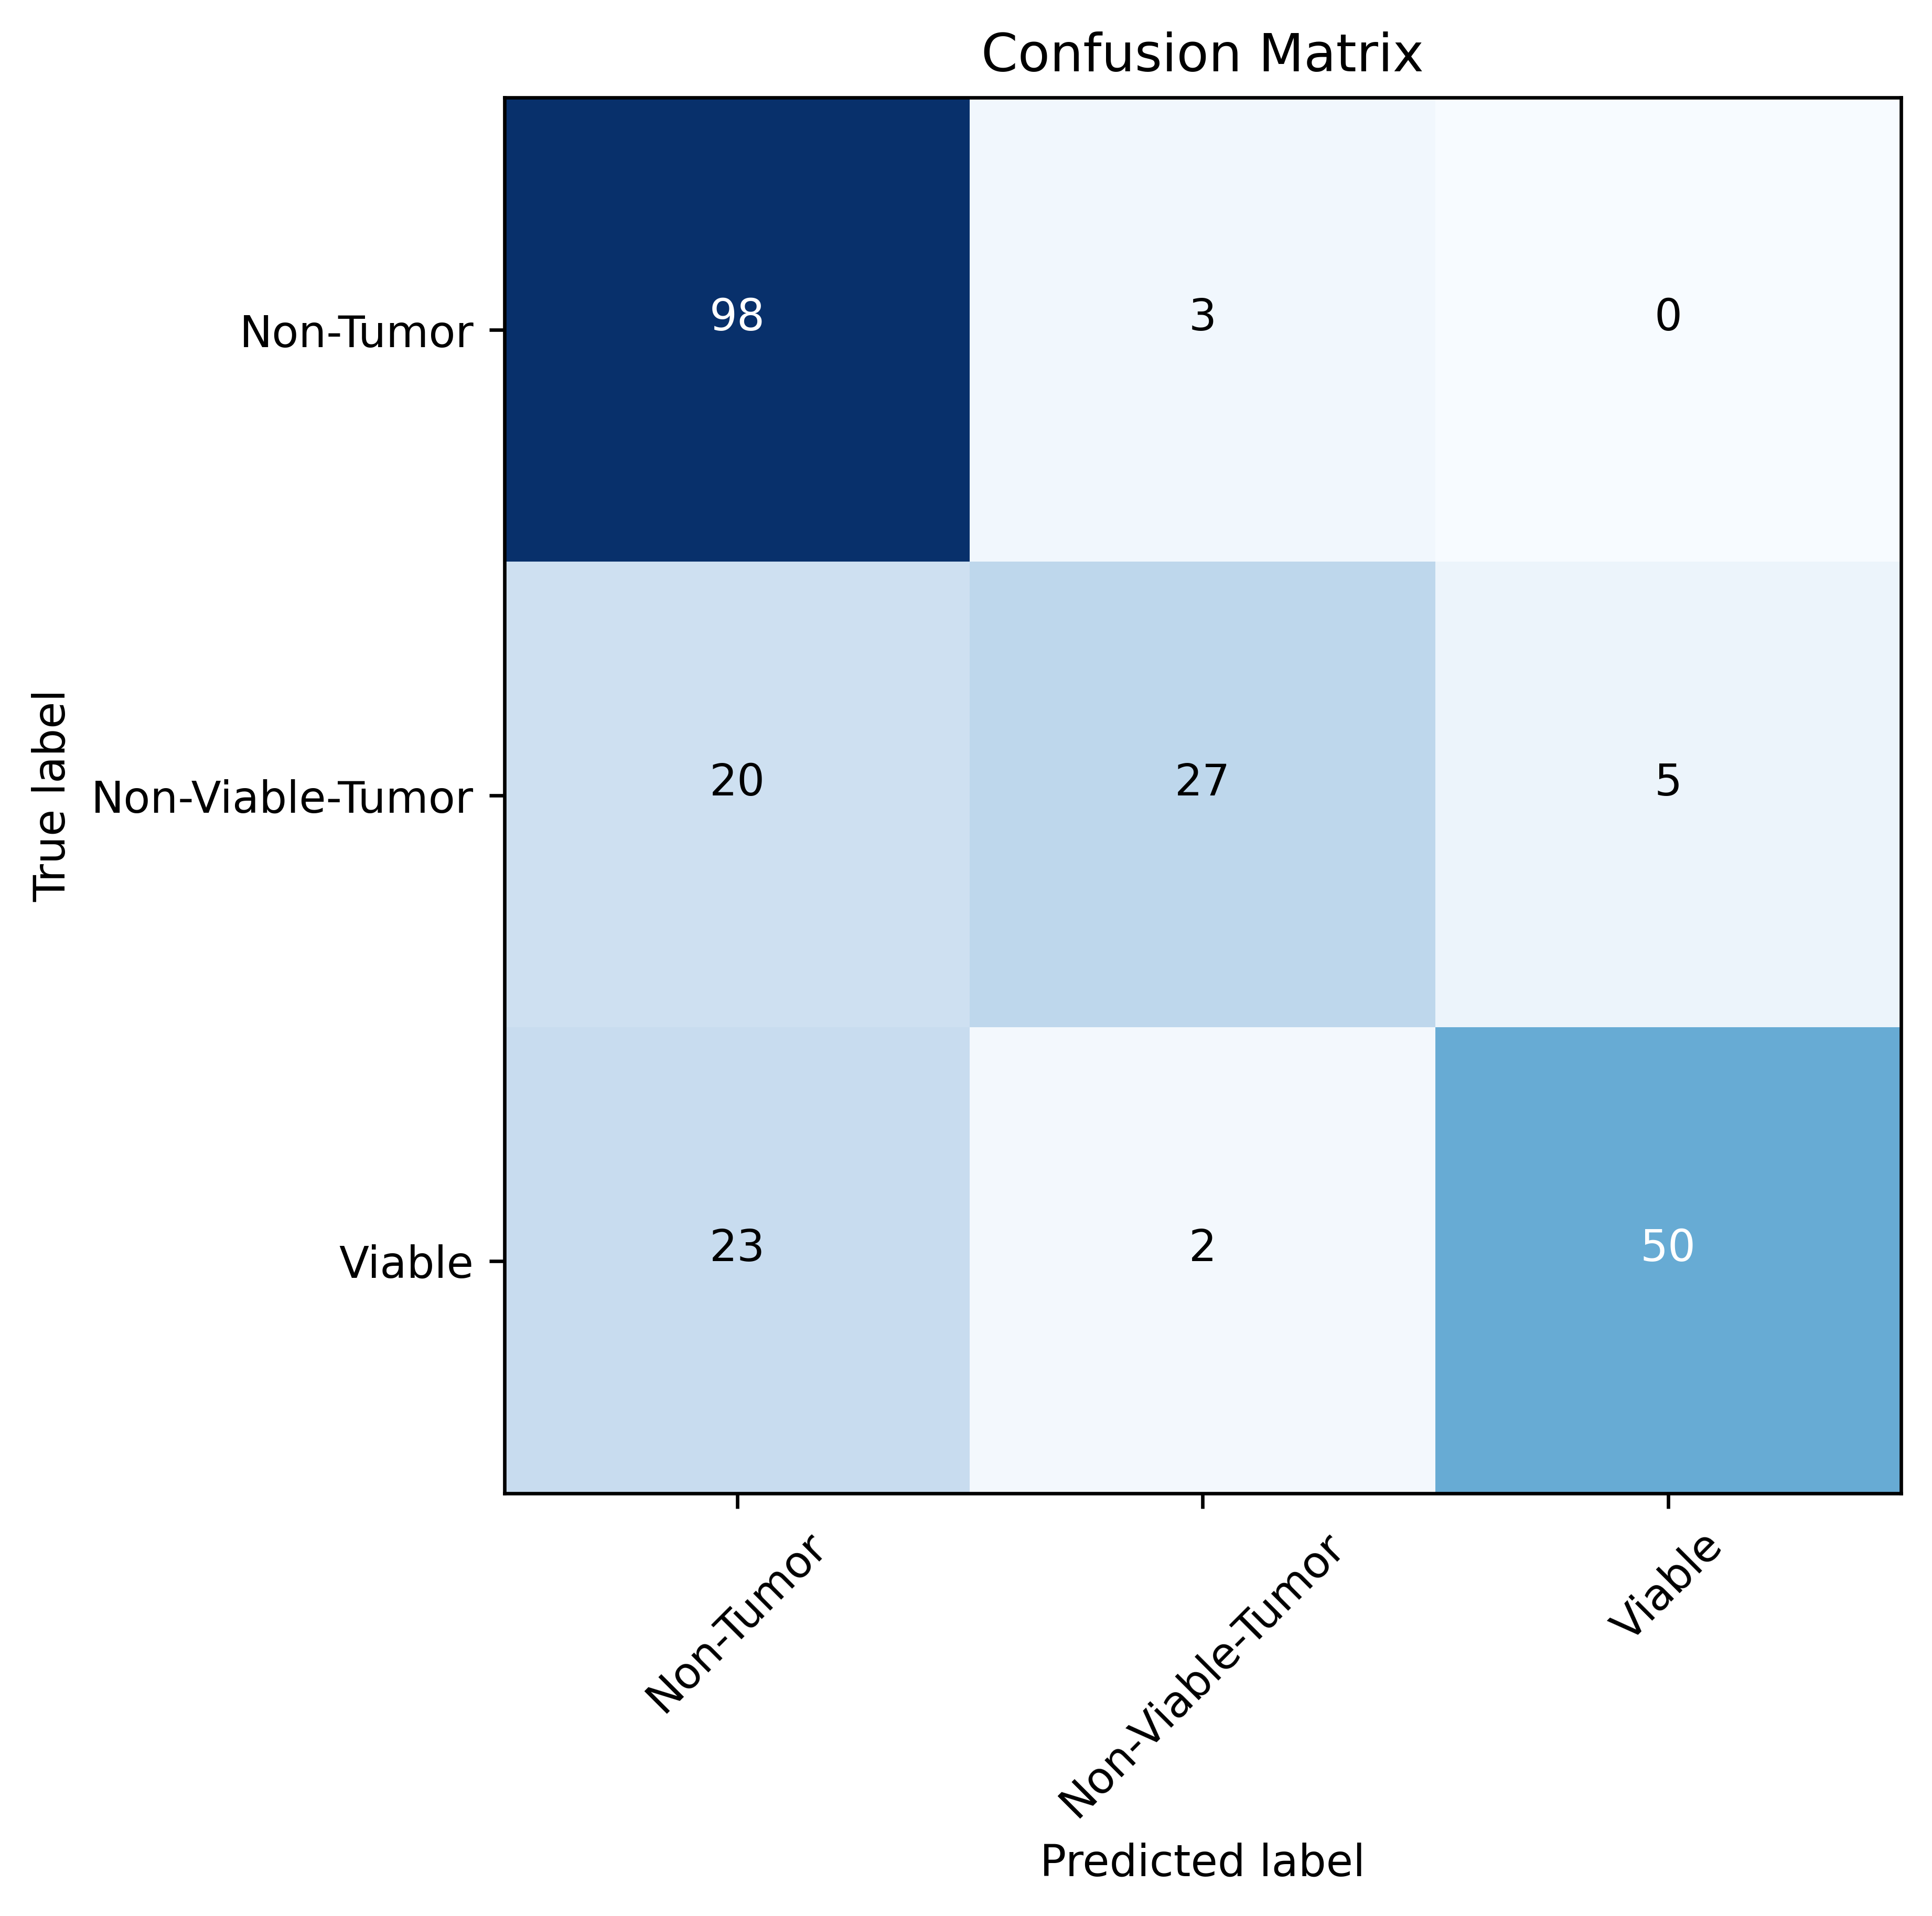

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, lgbm_pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

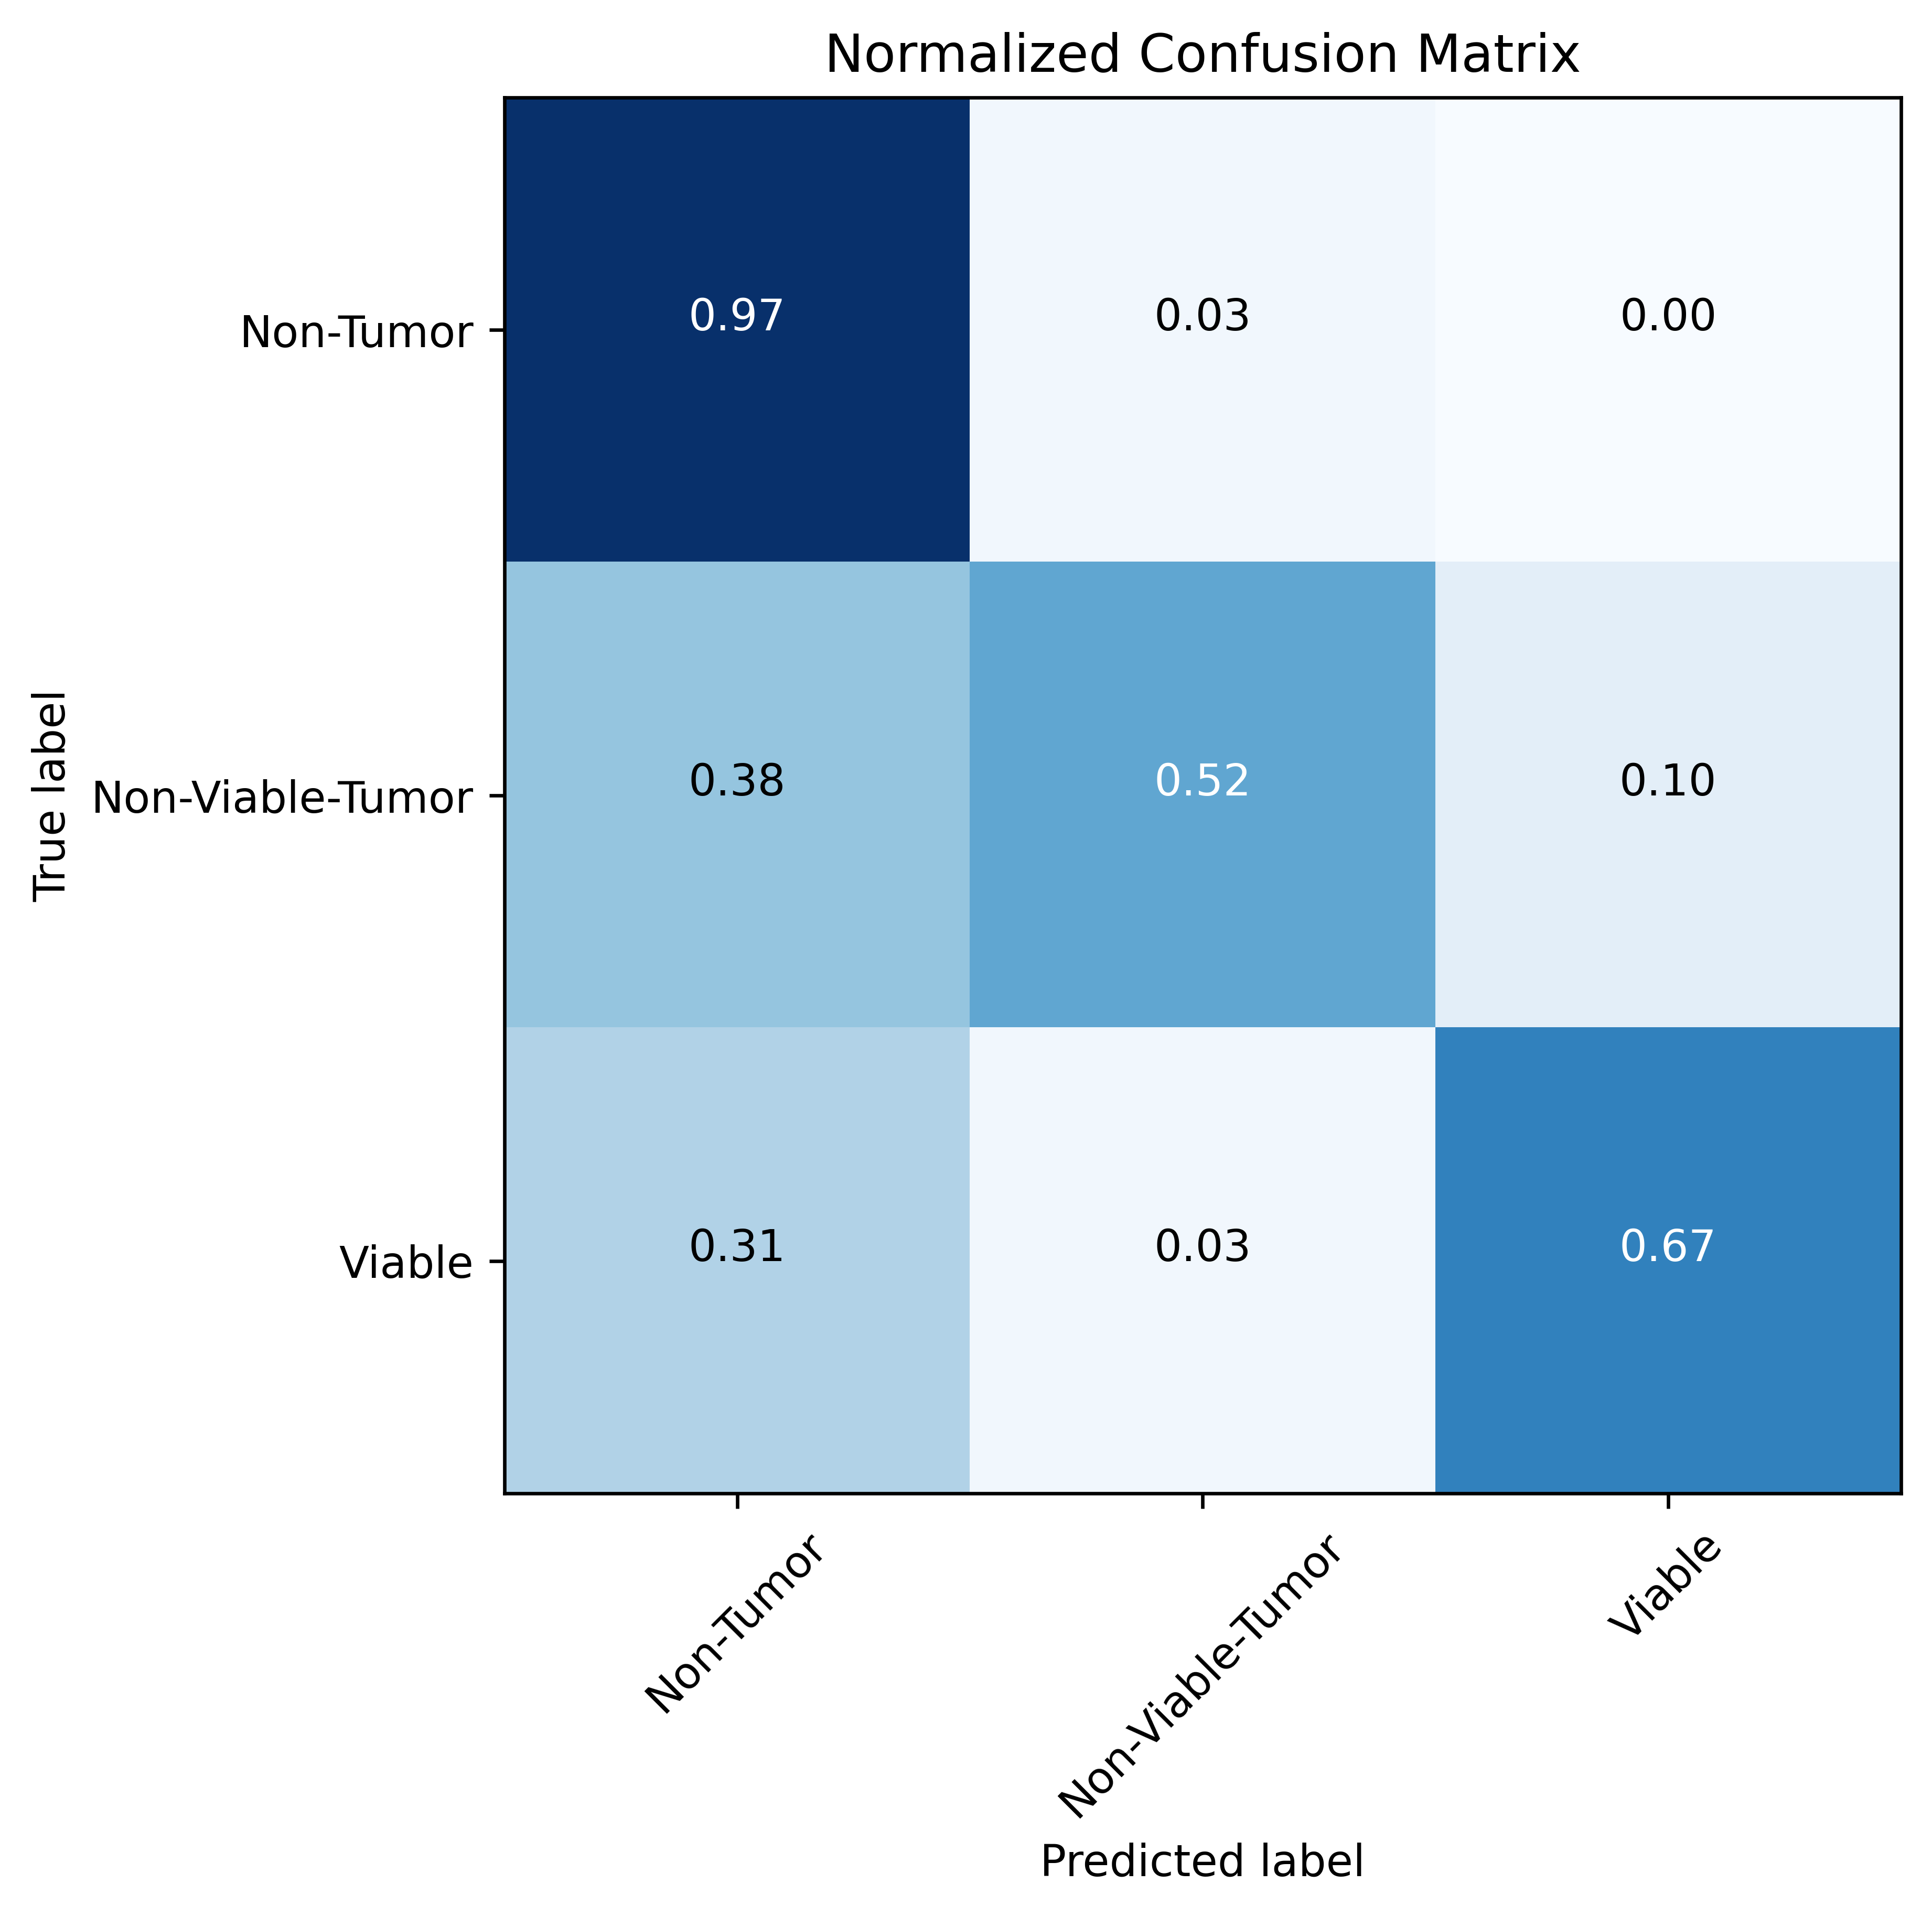

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

**Classification report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lgbm_pred))

              precision    recall  f1-score   support

           0       0.70      0.97      0.81       101
           1       0.84      0.52      0.64        52
           2       0.91      0.67      0.77        75

    accuracy                           0.77       228
   macro avg       0.82      0.72      0.74       228
weighted avg       0.80      0.77      0.76       228



**specificity and sensitivity**

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, lgbm_pred)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.695     	      0.907      	   0.642   
  1   Non-Viable-Tumor     0.844     	       0.36      	   0.967   
  2        Viable          0.909      	       0.51      	   0.962   


## Decision Tree (DT)

In [ ]:
# importing SVM module
# from sklearn.svm import SVC

In [ ]:
# kernel to be set radial bf 
svm_classifier = DecisionTreeClassifier(max_depth =7, ccp_alpha=0.025, random_state = 42)

# fit our training data into svm classifier
svm_classifier.fit(x_train_features, y_train)

DecisionTreeClassifier(ccp_alpha=0.025, max_depth=7, random_state=42)

In [ ]:
# predicting test data 
svm_pred = svm_classifier.predict(x_test_features)

In [ ]:
svm_pred

array([1, 1, 0, 0, 2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2,
       0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2,
       0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2,
       1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 0, 0, 1, 2, 1, 0, 0, 0,
       2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 0,
       2, 2, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 2, 2,
       1, 2, 2, 0, 1, 2, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 0,
       2, 0, 0, 1, 2, 1, 0, 2])

**Accuracy**

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, svm_pred)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.684


**ROC AUC**

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

svm_c = SVC(kernel='linear', probability= True).fit(x_train_features, y_train)

roc_auc = roc_auc_score(y_test, svm_c.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.978


**Matthews correlation coefficient (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, svm_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.505


**Confusion Matrix**

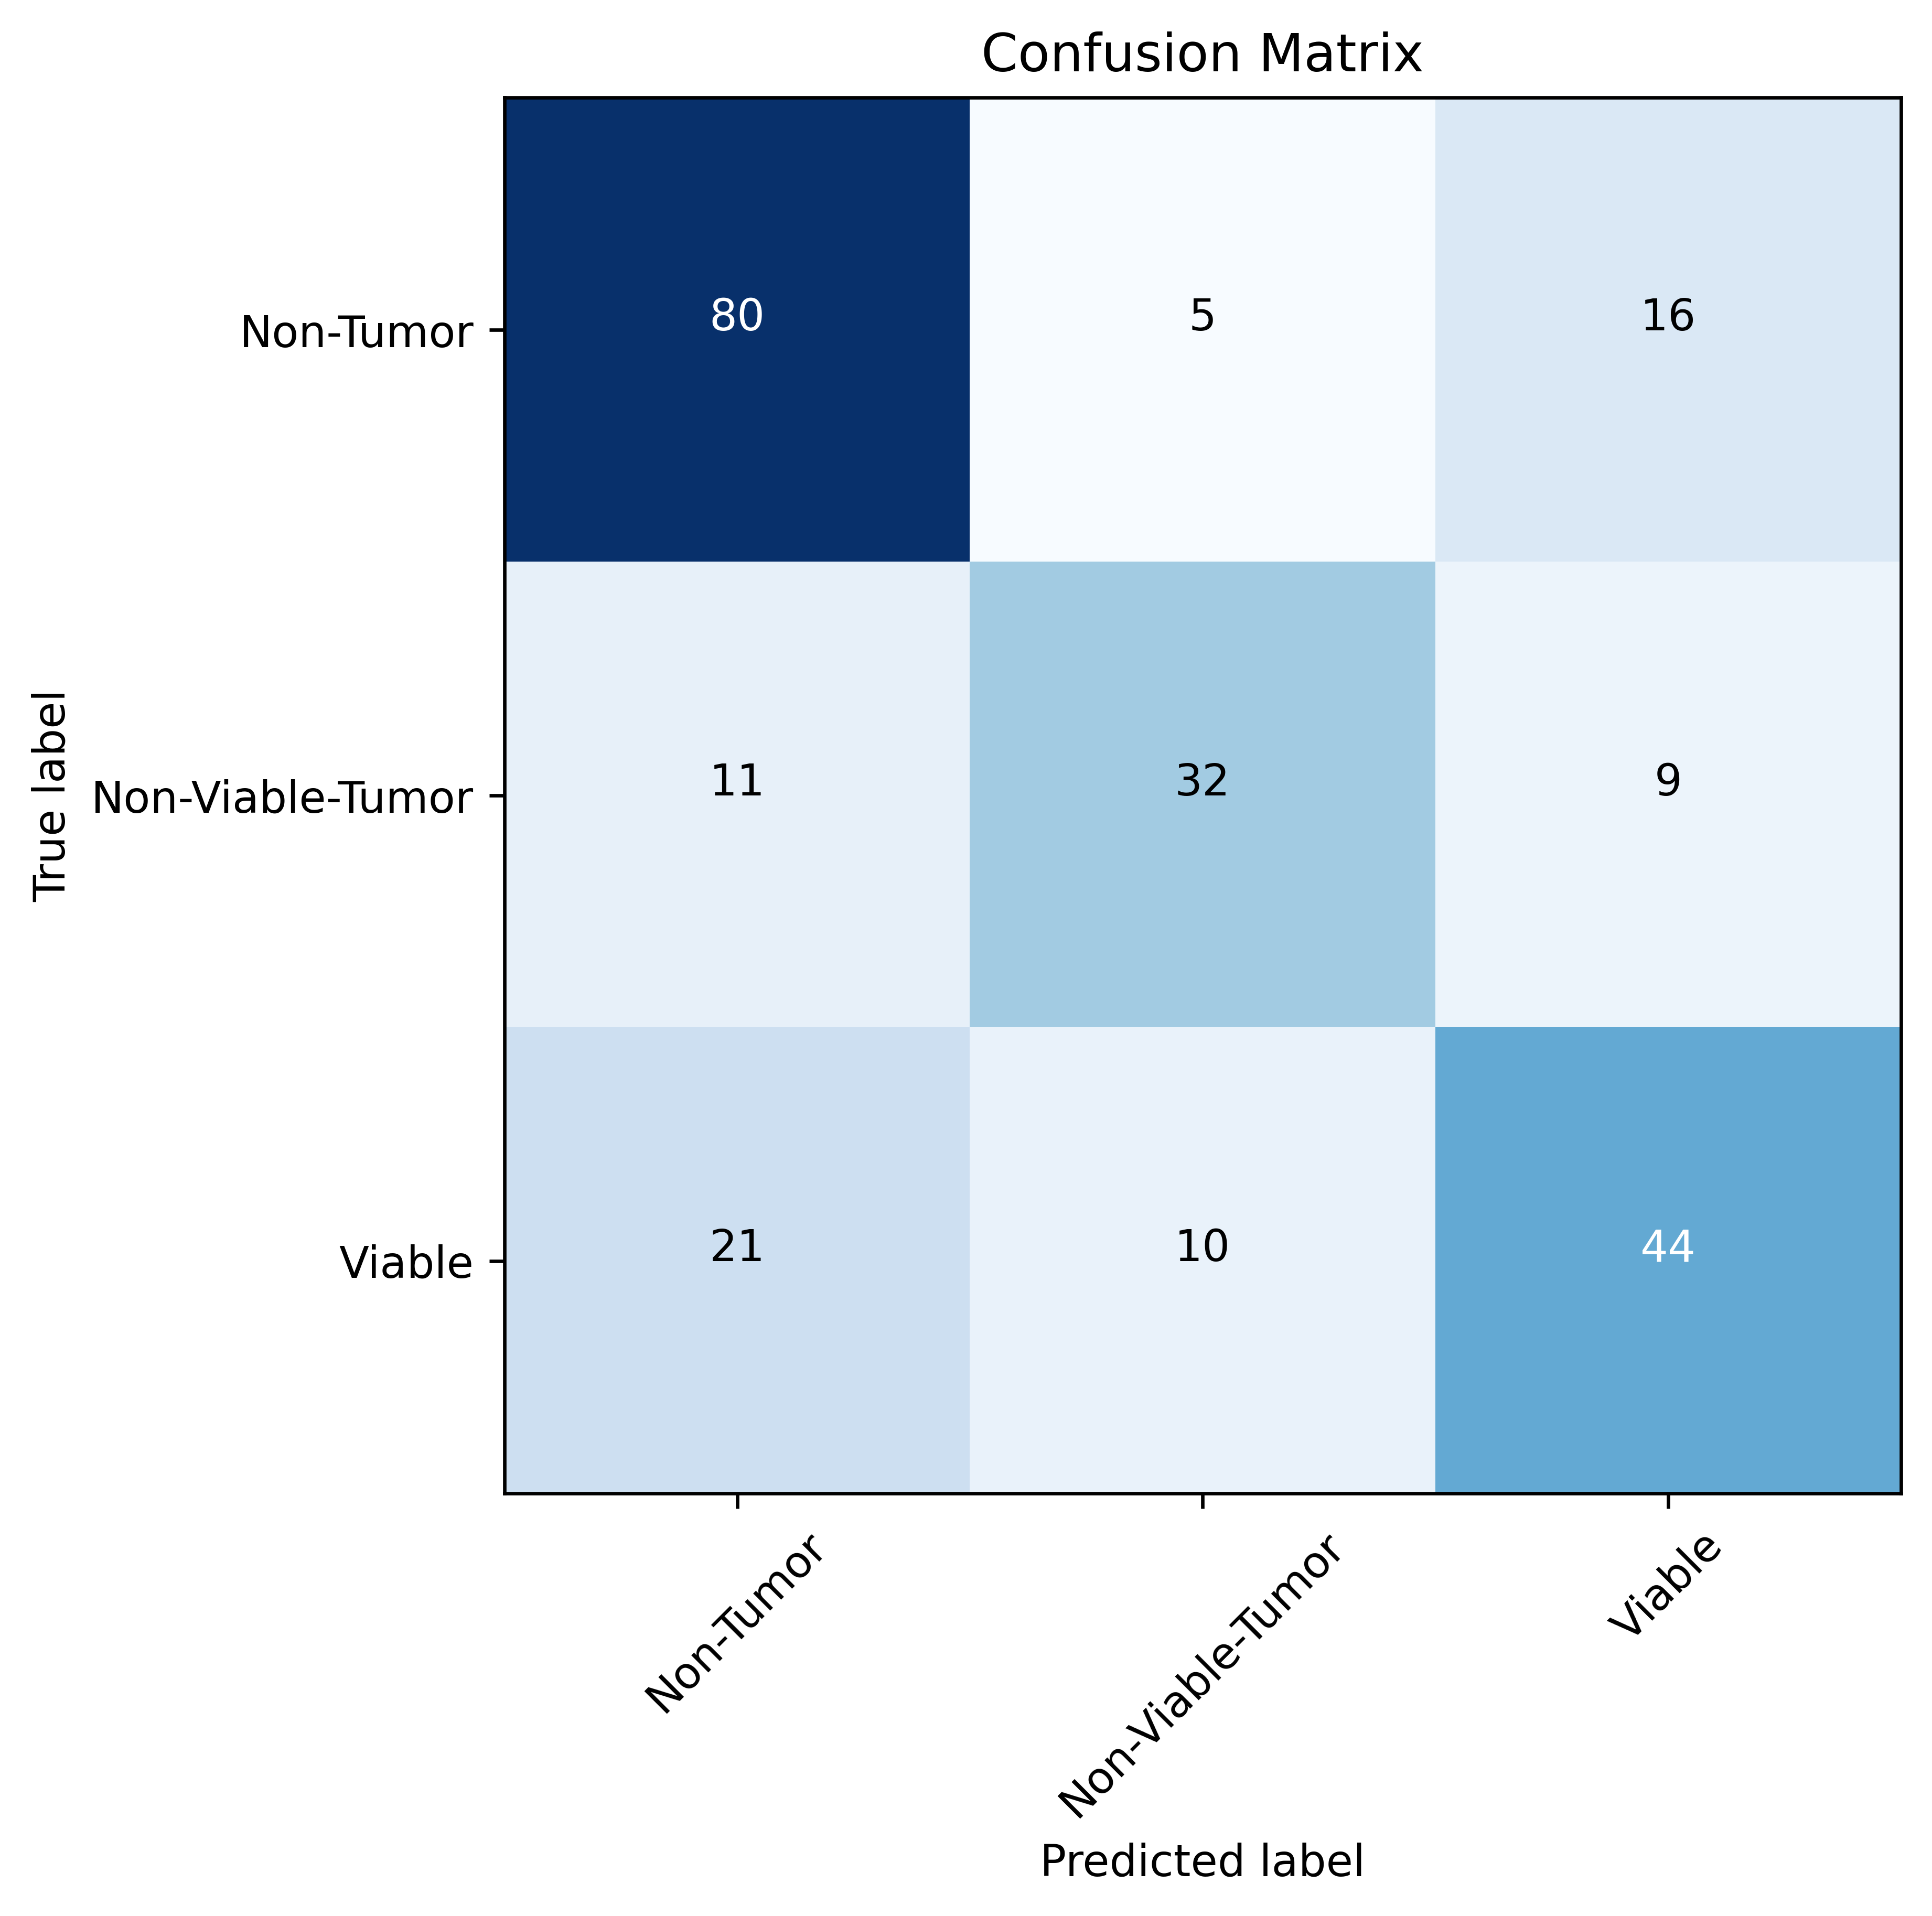

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, svm_pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

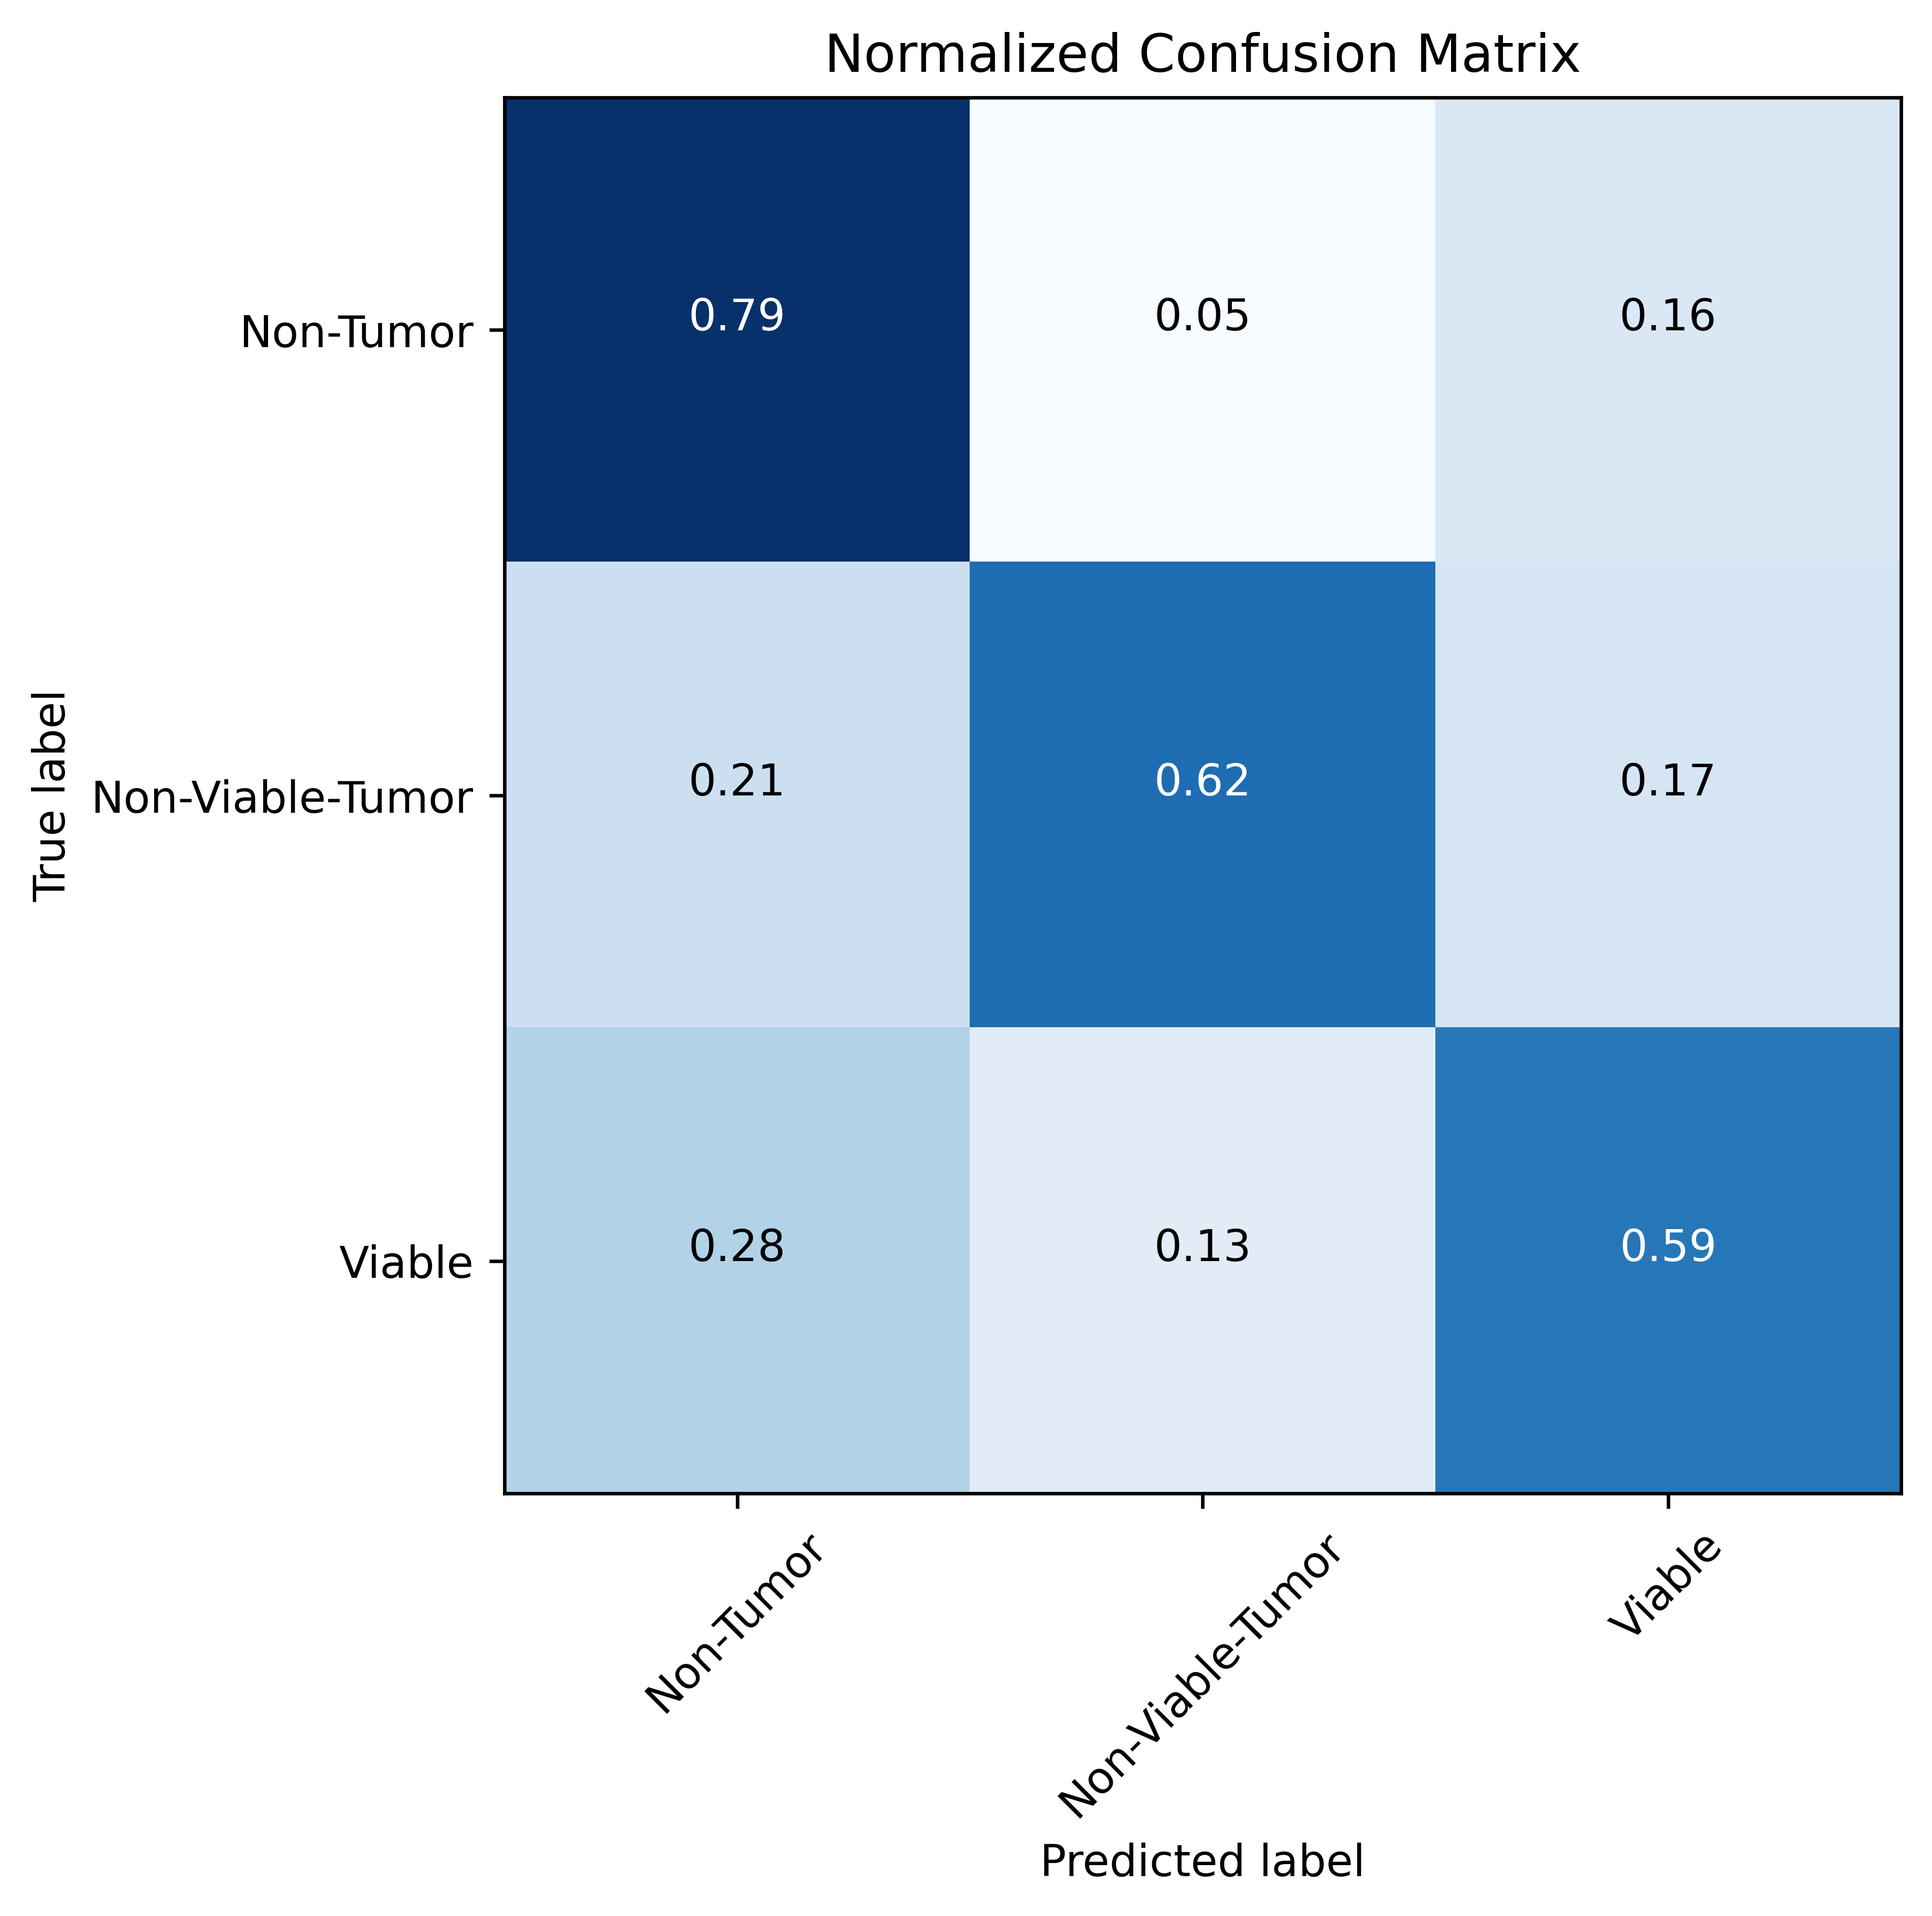

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       101
           1       0.68      0.62      0.65        52
           2       0.64      0.59      0.61        75

    accuracy                           0.68       228
   macro avg       0.68      0.66      0.67       228
weighted avg       0.68      0.68      0.68       228



**Sensitivity and Specificity**

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, svm_pred)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.714     	      0.667      	   0.704   
  1   Non-Viable-Tumor     0.681     	       0.36      	   0.892   
  2        Viable          0.638      	      0.484      	   0.818   


## Multi Layer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(x_train_features, y_train)

MLPClassifier(random_state=1)

In [ ]:
# predicting through test data
mlp_pred = mlp_classifier.predict(x_test_features)

In [ ]:
mlp_pred

array([1, 1, 0, 0, 2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2,
       0, 2, 0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2,
       2, 0, 0, 1, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2,
       1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 0, 0, 1, 2, 1, 0, 0, 0,
       2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 0,
       2, 2, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 2, 2,
       1, 2, 2, 0, 1, 2, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 2,
       1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 0,
       2, 0, 0, 1, 2, 0, 0, 2])

**Accuracy**

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.895


**ROC-AUC**

In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(x_test_features), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.977


**Matthews correlation coefficinet (MCC)**

In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.838


**confusion matrix**

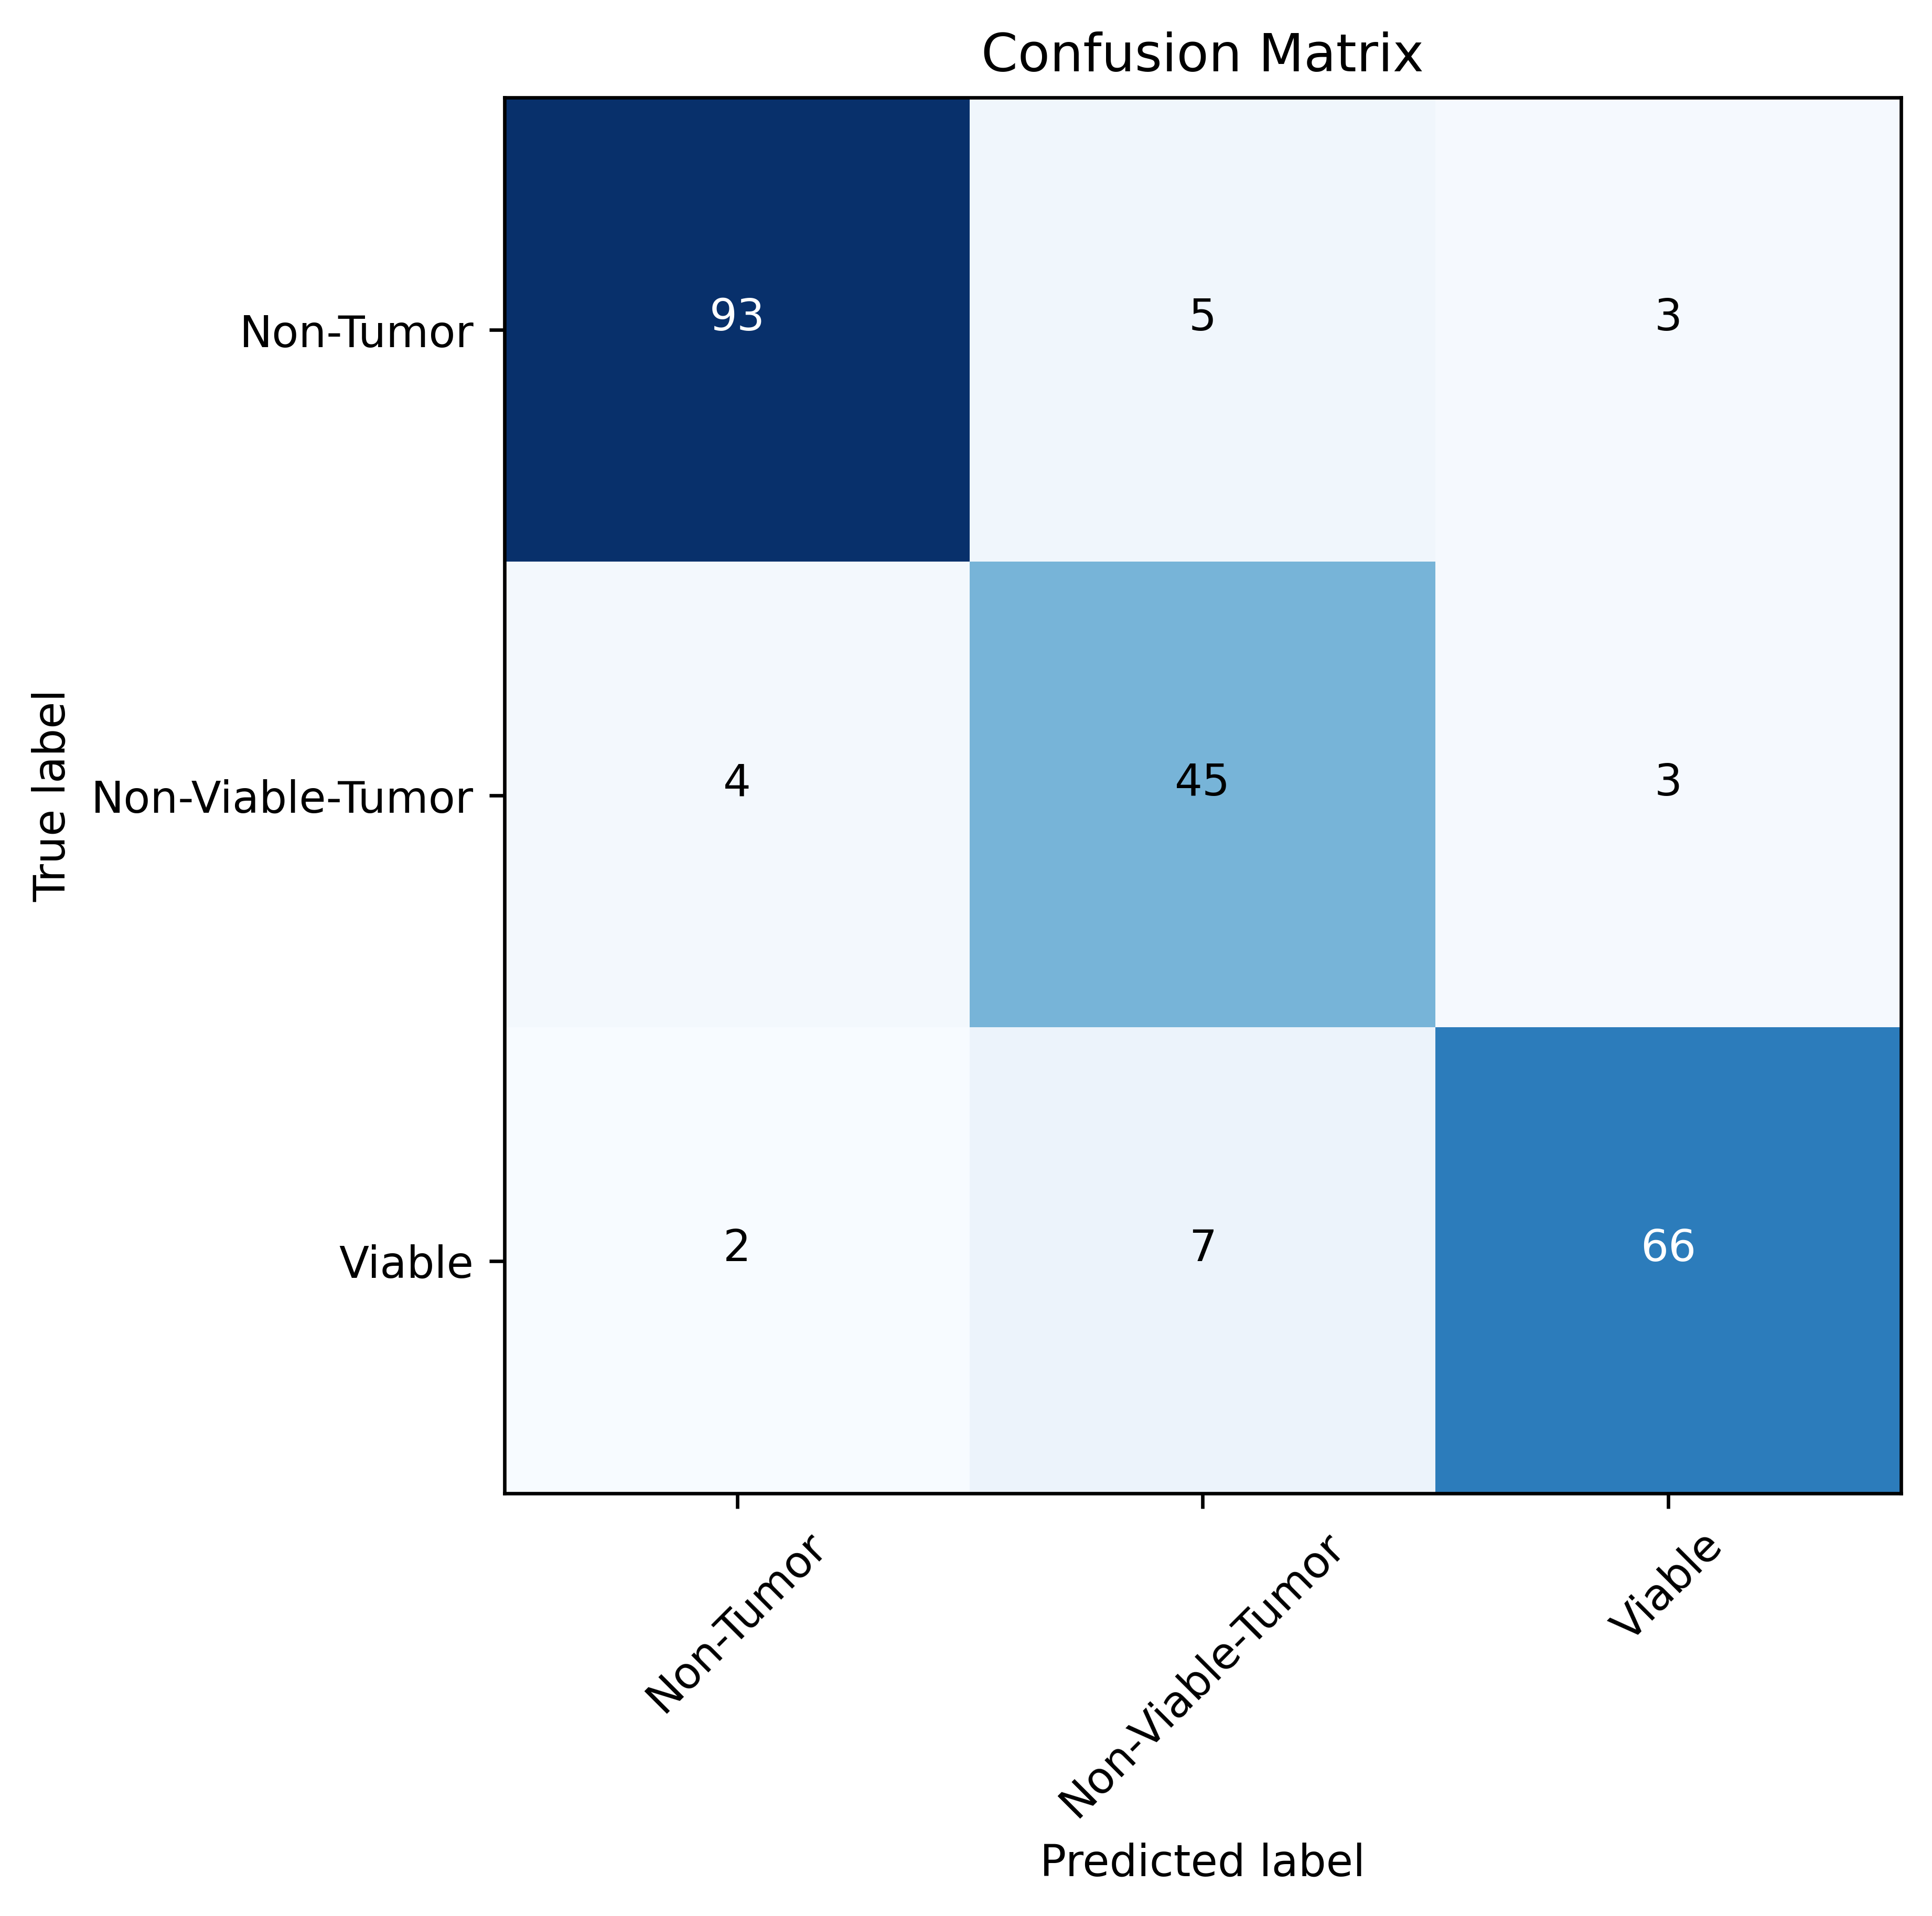

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, mlp_pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

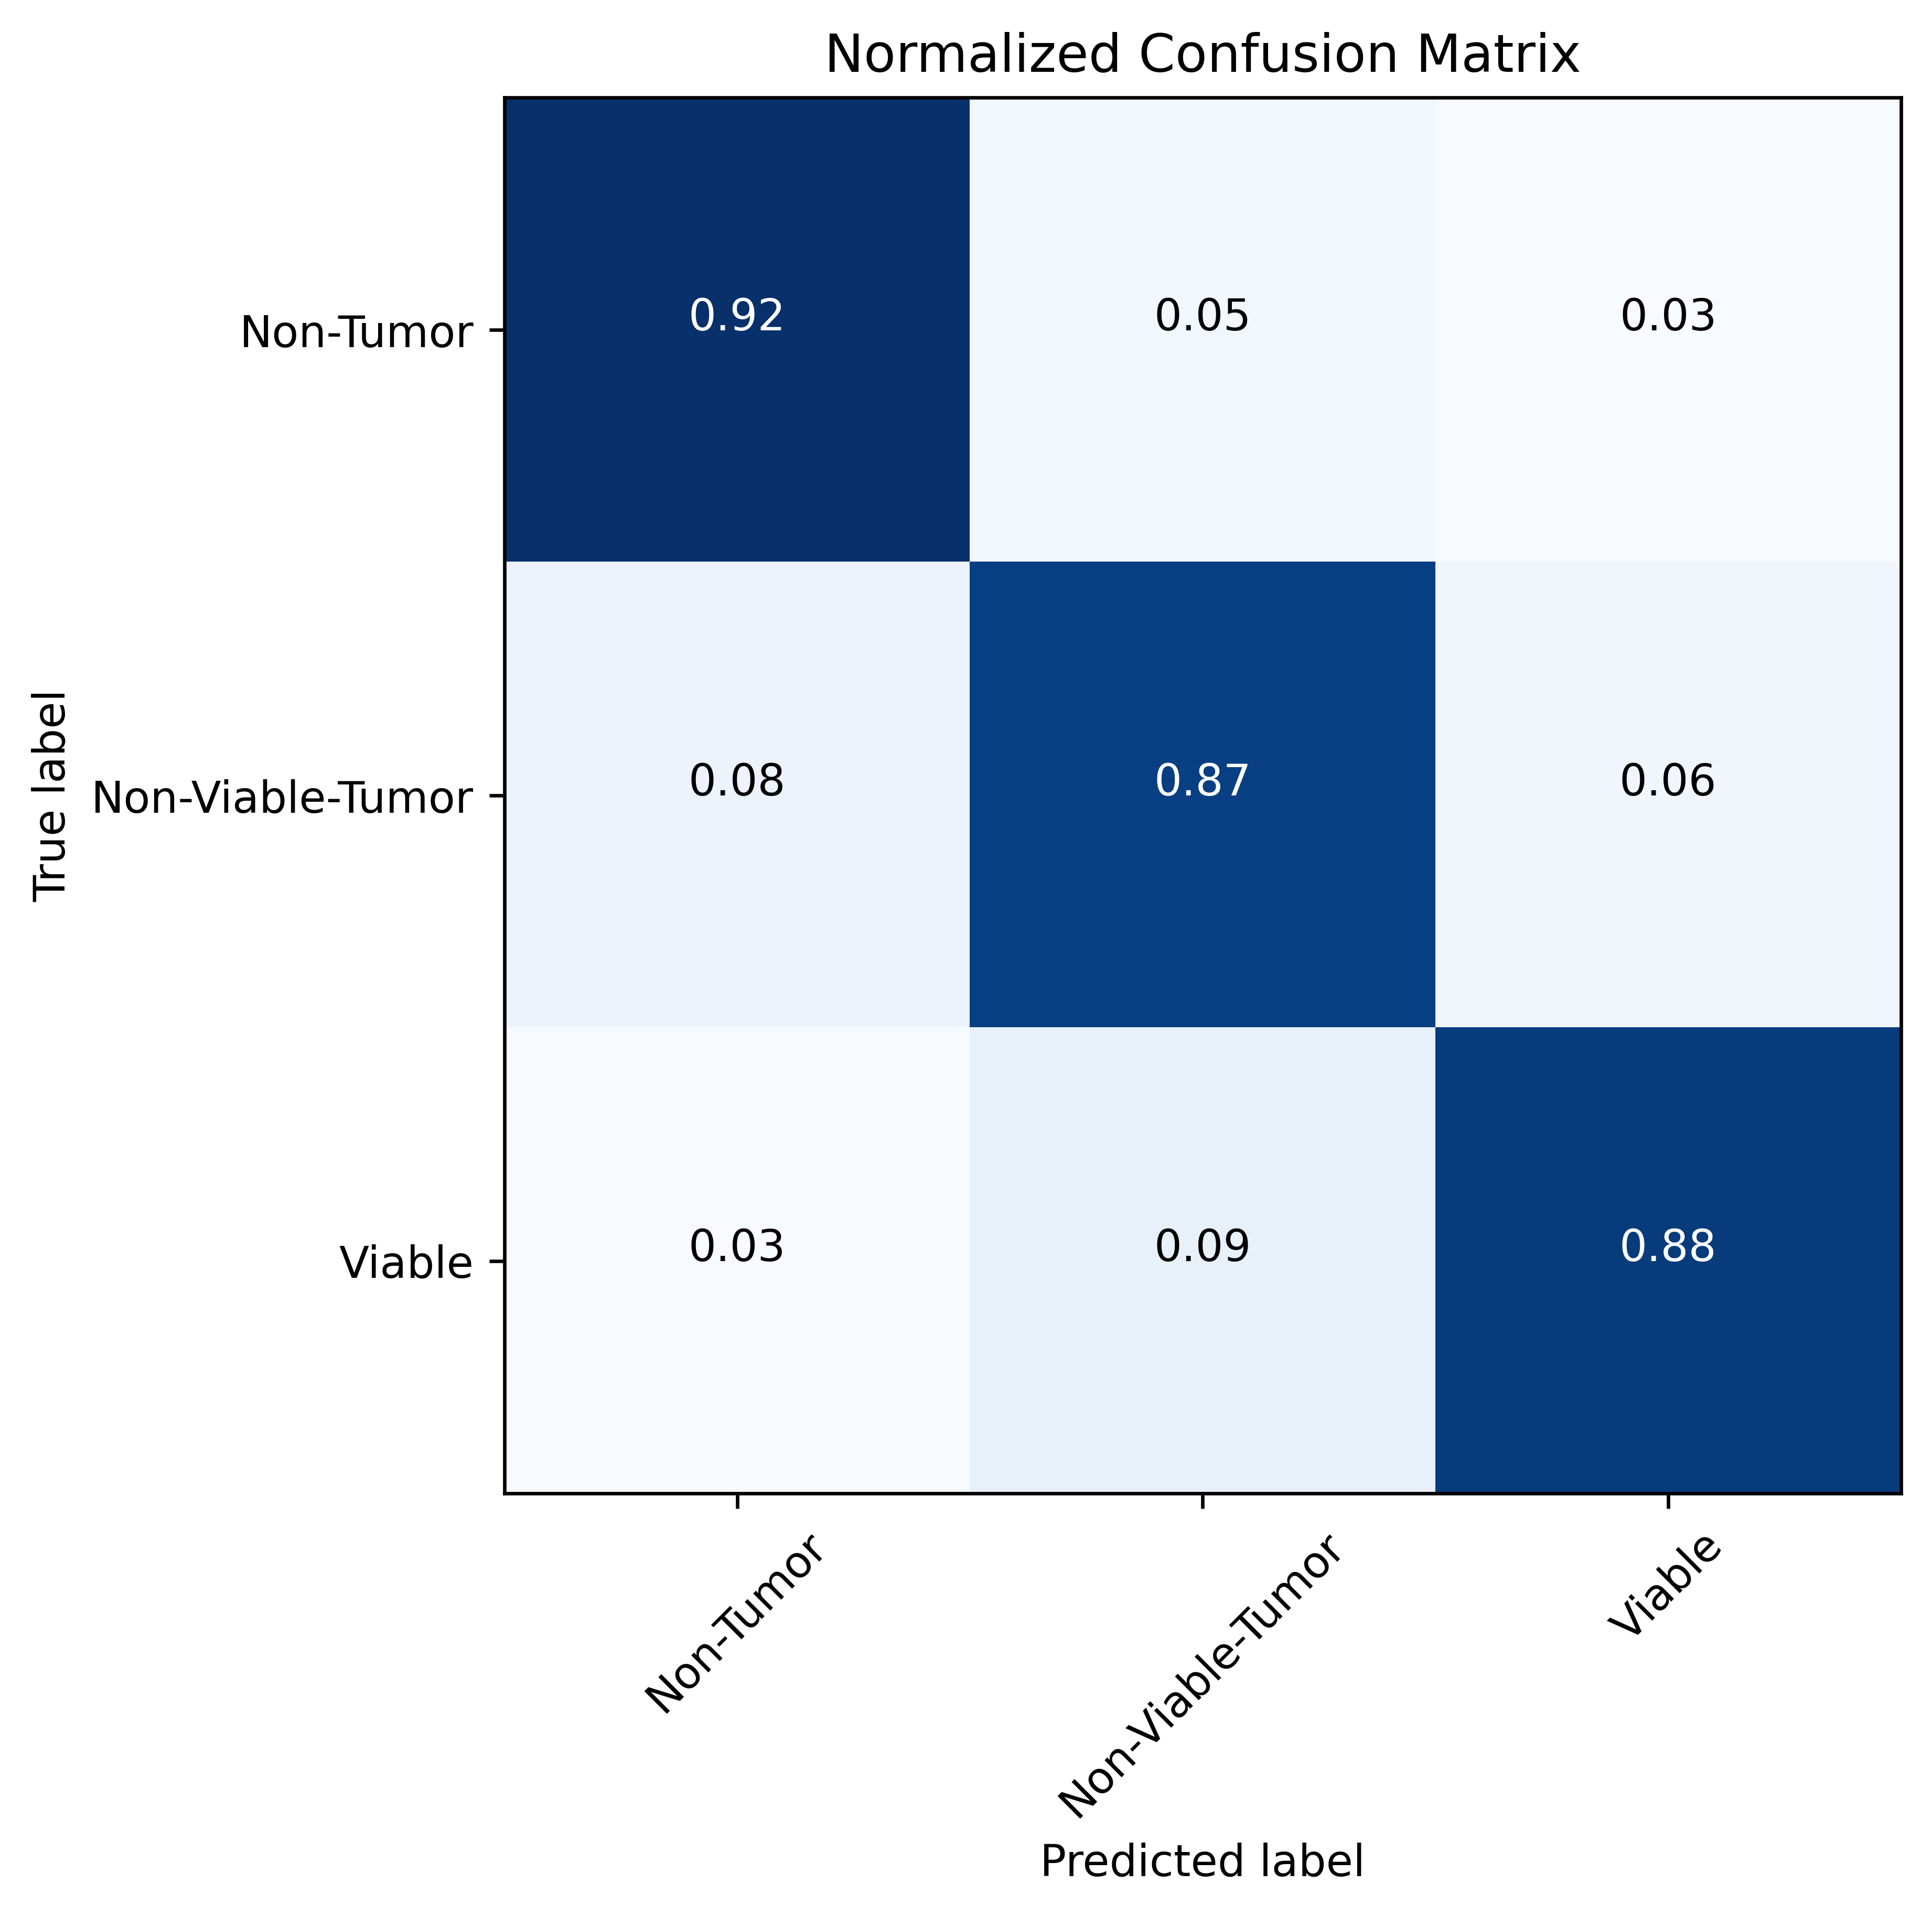

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= True)
plt.show()

**classification report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       101
           1       0.79      0.87      0.83        52
           2       0.92      0.88      0.90        75

    accuracy                           0.89       228
   macro avg       0.88      0.89      0.88       228
weighted avg       0.90      0.89      0.90       228



sensitivity and specificity

In [ ]:
c, tp, fp, tn, fn = perf_measure(y_test, mlp_pred)

# for class 0
tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

# precision= TP/(TP + FP)
precision_0 = tp_0 /(tp_0 + fp_0)
precision_0 = np.round(precision_0, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_0 = tp_0 / (tp_0 + fn_0)
recall_0 = np.round(recall_0, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_0 = tn_0 / (tn_0 + fp_0)
speci_0 = np.round(speci_0, 3)

#### for class 1
tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

# precision= TP/(TP + FP)
precision_1 = tp_1 /(tp_1 + fp_1)
precision_1 = np.round(precision_1, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_1 = tp_1 / (tp_1 + fn_1)
recall_1 = np.round(recall_1, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_1 = tn_1 / (tn_1 + fp_1)
speci_1 = np.round(speci_1, 3)

### for class 2
tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

# precision= TP/(TP + FP)
precision_2 = tp_2 /(tp_2 + fp_2)
precision_2 = np.round(precision_2, 3)

# recall (sensitivity) = TP/ (TP + FN)
recall_2 = tp_2 / (tp_2 + fn_2)
recall_2 = np.round(recall_2, 3)

# specificity(true negative rate) = TN / (TN + FP)
speci_2 = tn_2 / (tn_2 + fp_2)
speci_2 = np.round(speci_2, 3)

c_0, c_1, c_2 = 'Non-Tumor', 'Non-Viable-Tumor', 'Viable'
print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
print('--------------------------------------------------------------------------')
print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.939     	      0.838      	   0.949   
  1   Non-Viable-Tumor     0.789     	      0.789      	    0.93   
  2        Viable          0.917      	      0.786      	   0.958   
